# GO Term Enrichment

This notebook aims to generate and make sense of GO term enrichment results based on the DEG analysis results from the agewise and stagewise analysis notebooks. GO term enrichment will be performed using [g:Profiler](https://biit.cs.ut.ee/gprofiler/gost) via the [scanpy wrapper](https://scanpy.readthedocs.io/en/stable/generated/scanpy.queries.enrich.html).

In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import os
import statistics as stats
import seaborn as sns
import ast
FIG_PATH = '/group/ll005/cmcphan/notebooks/analysis/results/figures/'

In [2]:
# Log2 fold change cutoff value
LFC_CUTOFF = 1
# List of paths to DEG results
paths = ['/group/ll005/cmcphan/notebooks/analysis/results/herring/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/herring/stagewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/herring/stagewise/cell_type_split/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/human/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/human/stagewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/human/stagewise/cell_type_split/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/stagewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/stagewise/cell_type_split/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/cell_type_split/']
for path in paths:
    print(str('Starting on path: '+path))
    for file in os.listdir(path):
        full_path = str(path+file)
        if os.path.isdir(full_path):
            continue # Don't try to read directories
        # Figure out which species we're querying
        path_split = full_path.split('/')
        if path_split[7] == 'herring': # Herring data is always human
            species = 'hsapiens'
        elif path_split[7] == 'sepp': # Sepp may be human, mouse or opossum
            if path_split[8] == 'human':
                species = 'hsapiens'
            elif path_split[8] == 'mouse':
                species = 'mmusculus'
            elif path_split[8] == 'opossum':
                species = 'mdomestica'
            else:
                print('Path split for species returned an unexpected result')
                break
        else:
            print('Path split for dataset returned an unexpected result')
            break
        deg_results = pd.read_csv(full_path, index_col=0)
        # Get only significant (adjusted p-value <= 0.05) DEGs, split into upregulated and downregulated groups with sufficient LFC
        sig = deg_results[deg_results['padj'] <= 0.05]
        # Enrich for upregulated group and write to CSV
        sig_up = sig[sig['log2FoldChange'] >= LFC_CUTOFF] # Statistically significant, upregulated DEGs with LFC >= cutoff
        if len(sig_up) > 0:
            df = sc.queries.enrich([str(g) for g in sig_up.index.values], org=species, gprofiler_kwargs={'no_evidences':False})
            df.to_csv(str(path+'go_results/all_genes/'+'go_up_'+file))
        else:
            print(str('No passing upregulated genes to query: '+file))
        # Enrich for downregulated group and write to CSV
        sig_down = sig[sig['log2FoldChange'] <= -LFC_CUTOFF] # Statistically significant, downregulated DEGs with LFC <= -cutoff
        if len(sig_down) > 0:
            df = sc.queries.enrich([str(g) for g in sig_down.index.values], org=species, gprofiler_kwargs={'no_evidences':False})
            df.to_csv(str(path+'go_results/all_genes/'+'go_down_'+file))
        else:
            print(str('No passing downregulated genes to query: '+file))

Starting on path: /group/ll005/cmcphan/notebooks/analysis/results/herring/agewise/
Starting on path: /group/ll005/cmcphan/notebooks/analysis/results/herring/stagewise/
Starting on path: /group/ll005/cmcphan/notebooks/analysis/results/herring/stagewise/cell_type_split/
Starting on path: /group/ll005/cmcphan/notebooks/analysis/results/sepp/human/agewise/
Starting on path: /group/ll005/cmcphan/notebooks/analysis/results/sepp/human/stagewise/
Starting on path: /group/ll005/cmcphan/notebooks/analysis/results/sepp/human/stagewise/cell_type_split/
Starting on path: /group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/agewise/
Starting on path: /group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/stagewise/
Starting on path: /group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/stagewise/cell_type_split/
No passing upregulated genes to query: sepp_mouse_fetal_late_early_Non-Neu
No passing downregulated genes to query: sepp_mouse_fetal_late_early_Non-Neu
No passing downregulate

In [3]:
res = pd.read_csv('/group/ll005/cmcphan/notebooks/analysis/results/herring/stagewise/cell_type_split/go_results/all_genes/go_up_herring_infancy_fetal_PN', index_col=0)
res

source       native                                               name  \
0    GO:CC   GO:0030054                                      cell junction   
1    GO:CC   GO:0045202                                            synapse   
2    GO:CC   GO:0071944                                     cell periphery   
3    GO:CC   GO:0042995                                    cell projection   
4    GO:CC   GO:0016020                                           membrane   
..     ...          ...                                                ...   
721    HPA  HPA:0090921  cerebellum; GLUC cells - cytoplasm/membrane[≥Low]   
722  GO:BP   GO:0009581                     detection of external stimulus   
723  GO:BP   GO:0048813                             dendrite morphogenesis   
724     TF  TF:M07407_1    Factor: THAP1; motif: YTGCCCNNA; match class: 1   
725  GO:BP   GO:0048588                          developmental cell growth   

          p_value  significant  \
0    5.821609e-45         True   
1    1.856821e-44         True   
2    5.675948e-42         True   
3    2.580701e-35         True   
4    2.648655e-35         True   
..            ...          ...   
721  4.896256e-02         True   
722  4.939718e-02         True   
723  4.939718e-02         True   
724  4.989384e-02         True   
725  4.992710e-02         True   

                                           description  term_size  query_size  \
0    "A cellular component that forms a specialized...       2236        1181   
1    "The junction between an axon of one neuron an...       1475        1181   
2    "The broad region around and including the pla...       6269        1181   
3    "A prolongation or process extending from a ce...       2399        1181   
4    "A lipid bilayer along with all the proteins a...       9912        1181   
..                                                 ...        ...         ...   
721  cerebellum; GLUC cells - cytoplasm/membrane[≥Low]        195         717   
722  "The series of events in which an external sti...        142        1120   
723  "The process in which the anatomical structure...        142        1120   
724    Factor: THAP1; motif: YTGCCCNNA; match class: 1       4250        1217   
725  "The growth of a cell, where growth contribute...        234        1120   

     intersection_size  effective_domain_size  precision    recall    query  \
0                  286                  22115   0.242168  0.127907  query_1   
1                  221                  22115   0.187130  0.149831  query_1   
2                  555                  22115   0.469941  0.088531  query_1   
3                  278                  22115   0.235394  0.115882  query_1   
4                  743                  22115   0.629128  0.074960  query_1   
..                 ...                    ...        ...       ...      ...   
721                 27                  11019   0.037657  0.138462  query_1   
722                 21                  21017   0.018750  0.147887  query_1   
723                 21                  21017   0.018750  0.147887  query_1   
724                318                  20044   0.261298  0.074824  query_1   
725                 29                  21017   0.025893  0.123932  query_1   

                                        parents  \
0                                ['GO:0110165']   
1                                ['GO:0030054']   
2                                ['GO:0110165']   
3                                ['GO:0110165']   
4                                ['GO:0110165']   
..                                          ...   
721                             ['HPA:0090000']   
722                ['GO:0009605', 'GO:0051606']   
723  ['GO:0016358', 'GO:0048667', 'GO:0048812']   
724                               ['TF:M07407']   
725  ['GO:0016049', 'GO:0048468', 'GO:0048589']   

                                         intersections  \
0    ['AGRN', 'GABRD', 'AJAP1', 'KCNAB2', 'PDPN', '...   
1    ['

Since the Sepp datasets used the Ensembl ID as the index rather than the gene symbol, we need to be able to convert between the two for this search, because the GMT files contain only gene symbols. They were kept this way because not all of the genes had associated gene symbols, which means that this approach will miss a subset of the genes which do not have symbols.

In [2]:
sepp_human = ad.read_h5ad('/group/ll005/cmcphan/sepp_data/sepp_human_normal_reduced.h5ad')
sepp_mouse = ad.read_h5ad('/group/ll005/cmcphan/sepp_data/sepp_mouse_normal_reduced.h5ad')
sepp_opossum = ad.read_h5ad('/group/ll005/cmcphan/sepp_data/sepp_opossum_normal_reduced.h5ad')

In [3]:
sepp_human.var

ensembl_gene_id      gene_symbol  n_cells  n_cells_by_counts  \
ENSG00000237094  ENSG00000237094                      1800               1746   
ENSG00000230021  ENSG00000230021                     44552              43108   
ENSG00000248527  ENSG00000248527         MTATP6P1     9554               9042   
ENSG00000237491  ENSG00000237491        LINC01409    13605              13258   
ENSG00000228794  ENSG00000228794        LINC01128     9680               9417   
...                          ...              ...      ...                ...   
ENSG00000160951  ENSG00000160951           PTGER1       25                 22   
ENSG00000267470  ENSG00000267470       ZNF571-AS1       25                 25   
ENSG00000273212  ENSG00000273212                        33                 32   
ENSG00000232464  ENSG00000232464                        26                 26   
ENSG00000227895  ENSG00000227895  ENSG00000227895       26                 24   

                 mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
ENSG00000237094     0.010379           0.010326              98.987010   
ENSG00000230021     0.310859           0.270683              74.989702   
ENSG00000248527     0.065305           0.063261              94.754034   
ENSG00000237491     0.086238           0.082720              92.308005   
ENSG00000228794     0.059573           0.057866              94.536467   
...                      ...                ...                    ...   
ENSG00000160951     0.000128           0.000128              99.987236   
ENSG00000267470     0.000145           0.000145              99.985496   
ENSG00000273212     0.000186           0.000186              99.981434   
ENSG00000232464     0.000157           0.000157              99.984915   
ENSG00000227895     0.000139           0.000139              99.986076   

                 total_counts  log1p_total_counts  highly_variable  \
ENSG00000237094        1789.0            7.489971            False   
ENSG00000230021       53580.0           10.888949            False   
ENSG00000248527       11256.0            9.328746             True   
ENSG00000237491       14864.0            9.606765            False   
ENSG00000228794       10268.0            9.236885            False   
...                       ...                 ...              ...   
ENSG00000160951          22.0            3.135494            False   
ENSG00000267470          25.0            3.258096            False   
ENSG00000273212          32.0            3.496508            False   
ENSG00000232464          27.0            3.332205            False   
ENSG00000227895          24.0            3.218876            False   

                 highly_variable_rank     means  variances  variances_norm  
ENSG00000237094                   NaN  0.011024   0.011475        0.941618  
ENSG00000230021                   NaN  0.322642   0.390288        0.736464  
ENSG00000248527                 689.0  0.069617   0.176870        2.038356  
ENSG00000237491                   NaN  0.092721   0.107751        0.907059  
ENSG00000228794                   NaN  0.064522   0.072115        0.903836  
...                               ...       ...        ...             ...  
ENSG00000160951                   NaN  0.000140   0.000140        0.973339  
ENSG00000267470                   NaN  0.000159   0.000159        0.969425  
ENSG00000273212                   NaN  0.000204   0.000204        0.962557  
ENSG00000232464                   NaN  0.000172   0.000184        1.038841  
ENSG00000227895                   NaN  0.000153   0.000153        0.970648  

[27260 rows x 14 columns]

In [4]:
sepp_id_to_symbol = {}
for data in [sepp_human, sepp_mouse, sepp_opossum]:
    for var in data.var.index:
        symbol = data.var['gene_symbol'][var]
        if symbol == '':
            sepp_id_to_symbol[var] = None
        else:
            sepp_id_to_symbol[var] = symbol
sepp_id_to_symbol

{'ENSG00000237094': None,
 'ENSG00000230021': None,
 'ENSG00000248527': 'MTATP6P1',
 'ENSG00000237491': 'LINC01409',
 'ENSG00000228794': 'LINC01128',
 'ENSG00000272438': None,
 'ENSG00000188976': 'NOC2L',
 'ENSG00000272512': None,
 'ENSG00000188290': 'HES4',
 'ENSG00000187608': 'ISG15',
 'ENSG00000188157': 'AGRN',
 'ENSG00000131591': 'C1orf159',
 'ENSG00000162571': 'TTLL10',
 'ENSG00000078808': 'SDF4',
 'ENSG00000176022': 'B3GALT6',
 'ENSG00000160087': 'UBE2J2',
 'ENSG00000230415': 'LINC01786',
 'ENSG00000162572': 'SCNN1D',
 'ENSG00000131584': 'ACAP3',
 'ENSG00000169972': 'PUSL1',
 'ENSG00000127054': 'INTS11',
 'ENSG00000224051': 'CPTP',
 'ENSG00000107404': 'DVL1',
 'ENSG00000175756': 'AURKAIP1',
 'ENSG00000221978': 'CCNL2',
 'ENSG00000224870': 'MRPL20-AS1',
 'ENSG00000242485': 'MRPL20',
 'ENSG00000215915': 'ATAD3C',
 'ENSG00000160072': 'ATAD3B',
 'ENSG00000197785': 'ATAD3A',
 'ENSG00000160075': 'SSU72',
 'ENSG00000272106': None,
 'ENSG00000197530': 'MIB2',
 'ENSG00000248333': 'CDK11B'

In [5]:
# Invert conversion dictionary so we have the opposite conversion as well
sepp_symbol_to_id = {s: i for i, s in sepp_id_to_symbol.items()}
sepp_symbol_to_id

{None: 'ENSMODG00000027921',
 'MTATP6P1': 'ENSG00000248527',
 'LINC01409': 'ENSG00000237491',
 'LINC01128': 'ENSG00000228794',
 'NOC2L': 'ENSMODG00000018641',
 'HES4': 'ENSG00000188290',
 'ISG15': 'ENSG00000187608',
 'AGRN': 'ENSG00000188157',
 'C1orf159': 'ENSG00000131591',
 'TTLL10': 'ENSG00000162571',
 'SDF4': 'ENSMODG00000016449',
 'B3GALT6': 'ENSG00000176022',
 'UBE2J2': 'ENSG00000160087',
 'LINC01786': 'ENSG00000230415',
 'SCNN1D': 'ENSG00000162572',
 'ACAP3': 'ENSG00000131584',
 'PUSL1': 'ENSG00000169972',
 'INTS11': 'ENSMODG00000006290',
 'CPTP': 'ENSMODG00000006296',
 'DVL1': 'ENSMODG00000006382',
 'AURKAIP1': 'ENSG00000175756',
 'CCNL2': 'ENSG00000221978',
 'MRPL20-AS1': 'ENSG00000224870',
 'MRPL20': 'ENSG00000242485',
 'ATAD3C': 'ENSG00000215915',
 'ATAD3B': 'ENSG00000160072',
 'ATAD3A': 'ENSMODG00000006603',
 'SSU72': 'ENSG00000160075',
 'MIB2': 'ENSMODG00000006713',
 'CDK11B': 'ENSG00000248333',
 'SLC35E2B': 'ENSMODG00000006795',
 'CDK11A': 'ENSG00000008128',
 'SLC35E2A': 

In [8]:
# Read in all cell type split GO results for a given comparison
herring_upreg = []
herring_downreg = []
path = '/group/ll005/cmcphan/notebooks/analysis/results/herring/stagewise/cell_type_split/go_results/all_genes/'
comp = 'herring_infancy_fetal_'
cell_types = ['PN', 'IN', 'Oligo', 'Astro'] # Ignore non-neu group as it is made up of the oligo and astro groups
prefixes = ['go_up_', 'go_down_']
for prefix in prefixes:
    for cell_type in cell_types:
        res = pd.read_csv(str(path+prefix+comp+cell_type), index_col=0)
        if prefix == 'go_up_':
            herring_upreg.append(res)
        elif prefix == 'go_down_':
            herring_downreg.append(res)
herring_upreg

[    source       native                                               name  \
 0    GO:CC   GO:0030054                                      cell junction   
 1    GO:CC   GO:0045202                                            synapse   
 2    GO:CC   GO:0071944                                     cell periphery   
 3    GO:CC   GO:0042995                                    cell projection   
 4    GO:CC   GO:0016020                                           membrane   
 ..     ...          ...                                                ...   
 721    HPA  HPA:0090921  cerebellum; GLUC cells - cytoplasm/membrane[≥Low]   
 722  GO:BP   GO:0009581                     detection of external stimulus   
 723  GO:BP   GO:0048813                             dendrite morphogenesis   
 724     TF  TF:M07407_1    Factor: THAP1; motif: YTGCCCNNA; match class: 1   
 725  GO:BP   GO:0048588                          developmental cell growth   
 
           p_value  significant  \
 0    5.821609e

In [9]:
# Generate list of most enriched terms for each result, then collapse the list to remove duplicates
most_enriched_up = pd.DataFrame(columns=['source', 'native', 'name'])
most_enriched_down = pd.DataFrame(columns=['source', 'native', 'name'])
for res in herring_upreg:
    top = res[res['source'].isin(['GO:BP', 'GO:MF', 'KEGG', 'REAC', 'WP'])].sort_values(by='p_value')[:25][['source', 'native', 'name']]
    most_enriched_up = pd.concat([most_enriched_up, top])
for res in herring_downreg:
    top = res[res['source'].isin(['GO:BP', 'GO:MF', 'KEGG', 'REAC', 'WP'])].sort_values(by='p_value')[:25][['source', 'native', 'name']]
    most_enriched_down = pd.concat([most_enriched_down, top])

In [10]:
most_enriched_up.drop_duplicates()

source             native  \
6   GO:BP         GO:0007267   
7   GO:BP         GO:0099537   
8   GO:BP         GO:0007268   
9   GO:BP         GO:0098916   
10  GO:BP         GO:0099536   
13  GO:BP         GO:0032501   
14  GO:BP         GO:0048731   
17  GO:BP         GO:0065008   
18  GO:BP         GO:0030001   
19  GO:BP         GO:0007154   
21  GO:BP         GO:0006811   
22  GO:BP         GO:0023052   
23  GO:MF         GO:0046873   
24  GO:BP         GO:0048856   
25  GO:BP         GO:0034220   
27  GO:BP         GO:0007275   
28  GO:BP         GO:0006812   
31  GO:BP         GO:0050804   
32  GO:BP         GO:0099177   
33  GO:BP         GO:0032502   
34  GO:BP         GO:0098655   
35  GO:BP         GO:0098660   
36  GO:MF         GO:0015079   
37  GO:BP         GO:0042391   
39   REAC  REAC:R-HSA-112316   
23  GO:BP         GO:0006810   
33  GO:BP         GO:0051179   
36  GO:BP         GO:0055085   
42  GO:MF         GO:0022836   
44  GO:MF         GO:0005216   
45  GO:BP         GO:0051234   
47  GO:MF         GO:0005261   
8   GO:BP         GO:0007399   
13  GO:MF         GO:0015276   
14  GO:MF         GO:0022834   
15   KEGG         KEGG:04724   
20  GO:MF         GO:0008066   
21   REAC  REAC:R-HSA-112314   
22     WP          WP:WP5083   
23     WP          WP:WP2636   
27  GO:BP         GO:0022008   
30  GO:BP         GO:0048699   
31     WP          WP:WP4222   
32  GO:MF         GO:0099094   
38   KEGG         KEGG:04720   
39  GO:BP         GO:0030182   
41   REAC  REAC:R-HSA-112315   
43  GO:BP         GO:0007417   
46  GO:BP         GO:0098976   
50  GO:MF         GO:0004970   
52  GO:BP         GO:0050808   
55   KEGG         KEGG:05032   
21  GO:BP         GO:0009653   
25  GO:BP         GO:0048666   
30  GO:BP         GO:0050896   
35  GO:BP         GO:0050793   

                                                 name  
6                                 cell-cell signaling  
7                            trans-synaptic signaling  
8                      chemical synaptic transmission  
9                anterograde trans-synaptic signaling  
10                                 synaptic signaling  
13                   multicellular organismal process  
14                                 system development  
17                   regulation of biological quality  
18                                metal ion transport  
19                                 cell communication  
21                           monoatomic ion transport  
22                                          signaling  
23       metal ion transmembrane transporter activity  
24                   anatomical structure development  
25             monoatomic ion transmembrane transport  
27                 multicellular organism development  
28                        monoatomic cation transport  
31       modulation of chemical synaptic transmission  
32             regulation of trans-synaptic signaling  
33                              developmental process  
34          monoatomic cation transmembrane transport  
35              inorganic ion transmembrane transport  
36   potassium ion transmembrane transporter activity  
37                   regulation of membrane potential  
39                                    Neuronal System  
23                                          transport  
33                                       localization  
36                            transmembrane transport  
42                             gated channel activity  
44                    monoatomic ion channel activity  
45                      establishment of localization  
47                 monoatomic cation channel activity  
8                          nervous system development  
13       ligand-gated monoatomic ion channel activity  
14                      ligand-gated channel activity  
15                              Glutamatergic synapse  
20                        glutamate receptor activity  
21  Neurotransmitter receptors and postsynaptic si

In [11]:
most_enriched_down.drop_duplicates()

source            native                               name
0   GO:BP        GO:0065007              biological regulation
1   GO:BP        GO:0050789   regulation of biological process
2   GO:BP        GO:0050794     regulation of cellular process
3   GO:BP        GO:0048856   anatomical structure development
4   GO:BP        GO:0032502              developmental process
..    ...               ...                                ...
29   REAC  REAC:R-HSA-68877               Mitotic Prometaphase
19  GO:BP        GO:0007346   regulation of mitotic cell cycle
21  GO:BP        GO:0045787  positive regulation of cell cycle
28  GO:MF        GO:0008092       cytoskeletal protein binding
31  GO:BP        GO:0044770        cell cycle phase transition

[67 rows x 3 columns]

Some terms, e.g. 'multicellular organismal process', are extremely broad and cover a wide variety of processes, placing them in both the upregulated and downregulated groups, with different subsets of genes that all fall under the same term. To get a more specific idea of what processes are up or down regulated, use only terms with a minimum number of parents.

In [12]:
# Generate list of most enriched terms for each result, remove any terms that appear in both the up and down regulated lists
most_enriched_up = pd.DataFrame(columns=['source', 'native', 'name'])
most_enriched_down = pd.DataFrame(columns=['source', 'native', 'name'])
for up, down in zip(herring_upreg, herring_downreg):
    # Get only the GO terms which are not also in the opposite results for the same cell type - i.e. those that are 
    #    uniquely up- or down-regulated
    unique_up = up[up['source'].isin(['GO:BP', 'GO:MF', 'KEGG', 'REAC', 'WP'])].sort_values(by='p_value')[['source', 'native', 'name', 'parents']]
    unique_up_ids = [g for g in unique_up['native'].values if g not in down['native'].values]
    unique_up = up[up['native'].isin(unique_up_ids)]
    unique_up = unique_up.loc[[True if len(ast.literal_eval(p)) >= 2 else False for p in unique_up['parents'].values]]
    most_enriched_up = pd.concat([most_enriched_up, unique_up]).drop_duplicates()
    
    unique_down = down[down['source'].isin(['GO:BP', 'GO:MF', 'KEGG', 'REAC', 'WP'])].sort_values(by='p_value')[['source', 'native', 'name', 'parents']]
    unique_down_ids = [g for g in unique_down['native'].values if g not in up['native'].values]
    unique_down = down[down['native'].isin(unique_down_ids)]
    unique_down = unique_down.loc[[True if len(ast.literal_eval(p)) >= 2 else False for p in unique_down['parents'].values]]
    most_enriched_down = pd.concat([most_enriched_down, unique_down]).drop_duplicates()

In [13]:
most_enriched_up.reset_index(inplace=True, drop=True)
most_enriched_up = most_enriched_up.sort_values(by='p_value')
up = pd.DataFrame(columns=['source', 'native', 'name'])
for i in range(0, len(most_enriched_up)):
    if len(up) >= 25:
        break
    term = most_enriched_up.iloc[i]
    if term['native'] in up['native'].values:
        continue
    else:
        up.loc[len(up)] = term[['source', 'native', 'name']]
up

source      native                                              name
0   GO:BP  GO:0007267                               cell-cell signaling
1   GO:BP  GO:0050804      modulation of chemical synaptic transmission
2   GO:BP  GO:0099177            regulation of trans-synaptic signaling
3   GO:BP  GO:0055085                           transmembrane transport
4   GO:MF  GO:0005216                   monoatomic ion channel activity
5   GO:BP  GO:0034220            monoatomic ion transmembrane transport
6   GO:MF  GO:0005261                monoatomic cation channel activity
7   GO:BP  GO:0051049                           regulation of transport
8   GO:MF  GO:0046873      metal ion transmembrane transporter activity
9   GO:BP  GO:0032879                        regulation of localization
10  GO:BP  GO:0098655         monoatomic cation transmembrane transport
11  GO:MF  GO:0005244     voltage-gated monoatomic ion channel activity
12  GO:BP  GO:0071805             potassium ion transmembrane transport
13  GO:MF  GO:0022843  voltage-gated monoatomic cation channel activity
14  GO:MF  GO:0005267                        potassium channel activity
15  GO:BP  GO:0023051                           regulation of signaling
16  GO:BP  GO:0010646                  regulation of cell communication
17  GO:MF  GO:0015276      ligand-gated monoatomic ion channel activity
18  GO:BP  GO:0140352                                  export from cell
19  GO:BP  GO:0051716                     cellular response to stimulus
20  GO:BP  GO:0007165                               signal transduction
21  GO:MF  GO:0005249          voltage-gated potassium channel activity
22  GO:BP  GO:0032940                                 secretion by cell
23  GO:MF  GO:0099094   ligand-gated monoatomic cation channel activity
24  GO:BP  GO:0044057                      regulation of system process

In [14]:
most_enriched_down.reset_index(inplace=True, drop=True)
most_enriched_down = most_enriched_down.sort_values(by='p_value')
down = pd.DataFrame(columns=['source', 'native', 'name'])
for i in range(0, len(most_enriched_down)):
    if len(down) >= 25:
        break
    term = most_enriched_down.iloc[i]
    if term['native'] in down['native'].values:
        continue
    else:
        down.loc[len(down)] = term[['source', 'native', 'name']]
down

source      native                                               name
0   GO:BP  GO:1903047                         mitotic cell cycle process
1   GO:BP  GO:0022402                                 cell cycle process
2   GO:BP  GO:0140014                           mitotic nuclear division
3   GO:BP  GO:0000070               mitotic sister chromatid segregation
4   GO:BP  GO:0000819                       sister chromatid segregation
5   GO:BP  GO:0010564                   regulation of cell cycle process
6   GO:BP  GO:0051726                           regulation of cell cycle
7   GO:BP  GO:0007346                   regulation of mitotic cell cycle
8   GO:BP  GO:0045787                  positive regulation of cell cycle
9   GO:BP  GO:0090068          positive regulation of cell cycle process
10  GO:BP  GO:0000226              microtubule cytoskeleton organization
11  GO:BP  GO:0044772                mitotic cell cycle phase transition
12  GO:BP  GO:0019219  regulation of nucleobase-containing compound m...
13  GO:BP  GO:1901987          regulation of cell cycle phase transition
14  GO:BP  GO:0051983               regulation of chromosome segregation
15  GO:BP  GO:0051252                regulation of RNA metabolic process
16  GO:BP  GO:0007088             regulation of mitotic nuclear division
17  GO:BP  GO:1901990  regulation of mitotic cell cycle phase transition
18  GO:BP  GO:0007051                               spindle organization
19  GO:BP  GO:0033043               regulation of organelle organization
20  GO:BP  GO:0080090            regulation of primary metabolic process
21  GO:BP  GO:0051783                     regulation of nuclear division
22  GO:BP  GO:1905818                regulation of chromosome separation
23  GO:BP  GO:2001141             regulation of RNA biosynthetic process
24  GO:BP  GO:1902850  microtubule cytoskeleton organization involved...

In [15]:
most_enriched = pd.concat([up, down])
most_enriched.reset_index(inplace=True, drop=True)
most_enriched.drop_duplicates()

source      native                                               name
0   GO:BP  GO:0007267                                cell-cell signaling
1   GO:BP  GO:0050804       modulation of chemical synaptic transmission
2   GO:BP  GO:0099177             regulation of trans-synaptic signaling
3   GO:BP  GO:0055085                            transmembrane transport
4   GO:MF  GO:0005216                    monoatomic ion channel activity
5   GO:BP  GO:0034220             monoatomic ion transmembrane transport
6   GO:MF  GO:0005261                 monoatomic cation channel activity
7   GO:BP  GO:0051049                            regulation of transport
8   GO:MF  GO:0046873       metal ion transmembrane transporter activity
9   GO:BP  GO:0032879                         regulation of localization
10  GO:BP  GO:0098655          monoatomic cation transmembrane transport
11  GO:MF  GO:0005244      voltage-gated monoatomic ion channel activity
12  GO:BP  GO:0071805              potassium ion transmembrane transport
13  GO:MF  GO:0022843   voltage-gated monoatomic cation channel activity
14  GO:MF  GO:0005267                         potassium channel activity
15  GO:BP  GO:0023051                            regulation of signaling
16  GO:BP  GO:0010646                   regulation of cell communication
17  GO:MF  GO:0015276       ligand-gated monoatomic ion channel activity
18  GO:BP  GO:0140352                                   export from cell
19  GO:BP  GO:0051716                      cellular response to stimulus
20  GO:BP  GO:0007165                                signal transduction
21  GO:MF  GO:0005249           voltage-gated potassium channel activity
22  GO:BP  GO:0032940                                  secretion by cell
23  GO:MF  GO:0099094    ligand-gated monoatomic cation channel activity
24  GO:BP  GO:0044057                       regulation of system process
25  GO:BP  GO:1903047                         mitotic cell cycle process
26  GO:BP  GO:0022402                                 cell cycle process
27  GO:BP  GO:0140014                           mitotic nuclear division
28  GO:BP  GO:0000070               mitotic sister chromatid segregation
29  GO:BP  GO:0000819                       sister chromatid segregation
30  GO:BP  GO:0010564                   regulation of cell cycle process
31  GO:BP  GO:0051726                           regulation of cell cycle
32  GO:BP  GO:0007346                   regulation of mitotic cell cycle
33  GO:BP  GO:0045787                  positive regulation of cell cycle
34  GO:BP  GO:0090068          positive regulation of cell cycle process
35  GO:BP  GO:0000226              microtubule cytoskeleton organization
36  GO:BP  GO:0044772                mitotic cell cycle phase transition
37  GO:BP  GO:0019219  regulation of nucleobase-containing compound m...
38  GO:BP  GO:1901987          regulation of cell cycle phase transition
39  GO:BP  GO:0051983               regulation of chromosome segregation
40  GO:BP  GO:0051252                regulation of RNA metabolic process
41  GO:BP  GO:0007088             regulation of mitotic nuclear division
42  GO:BP  GO:1901990  regulation of mitotic cell cycle phase transition
43  GO:BP  GO:0007051                               spindle organization
44  GO:BP  GO:0033043               regulation of organelle organization
45  GO:BP  GO:0080090            regulation of primary metabolic process
46  GO:BP  GO:0051783                     regulation of nuclear division
47  GO:BP  GO:1905818                regulation of chromosome separation
48  GO:BP  GO:2001141             regulation of RNA biosynthetic process
49  GO:BP  GO:1902850  microtubule cytoskeleton organization involved...

In [16]:
# Combine enriched terms into a single list and compile expression data for each term in each group
dotplot_df = pd.DataFrame(columns=['dataset', 'cell_type', 'go_id', 'go_name', 'num_genes', 'mean_lfc'])
path = '/group/ll005/cmcphan/notebooks/analysis/results/herring/stagewise/cell_type_split/'
comp = 'herring_infancy_fetal_'
cell_types = ['PN', 'IN', 'Oligo', 'Astro']
herring_dges = {}
herring_go = {}
for cell_type in cell_types: # Get all relevant DGE results
    herring_dges[cell_type] = pd.read_csv(str(path+comp+cell_type), index_col=0)
    go_up = pd.read_csv(str(path+'go_results/all_genes/go_up_'+comp+cell_type), index_col=0)
    go_down = pd.read_csv(str(path+'go_results/all_genes/go_down_'+comp+cell_type), index_col=0)
    go_combined = pd.concat([go_up, go_down])
    herring_go[cell_type] = go_combined
for cell_type, dge in herring_dges.items():
    for i in most_enriched.index:
        term = most_enriched.loc[i]
        # Get list of intersecting genes for term
        intersections = herring_go[cell_type][herring_go[cell_type]['native'] == term['native']]['intersections']
        gene_list = []
        for l in intersections:
            gene_list = gene_list + ast.literal_eval(l)
        # Gene list now contains all DEGs for this cell type associated with the current GO term
        # Get expression data for relevant genes from DEG result
        if len(gene_list) > 0:
            gene_data = herring_dges[cell_type].loc[gene_list]
            mean_lfc = stats.mean(gene_data['log2FoldChange'])
        else:
            mean_lfc = np.nan
        dotplot_df.loc[len(dotplot_df)] = ['herring_human_birth', cell_type, term['native'], term['name'], len(gene_list), mean_lfc]
dotplot_df

dataset cell_type       go_id  \
0    herring_human_birth        PN  GO:0007267   
1    herring_human_birth        PN  GO:0050804   
2    herring_human_birth        PN  GO:0099177   
3    herring_human_birth        PN  GO:0055085   
4    herring_human_birth        PN  GO:0005216   
..                   ...       ...         ...   
195  herring_human_birth     Astro  GO:0080090   
196  herring_human_birth     Astro  GO:0051783   
197  herring_human_birth     Astro  GO:1905818   
198  herring_human_birth     Astro  GO:2001141   
199  herring_human_birth     Astro  GO:1902850   

                                               go_name  num_genes  mean_lfc  
0                                  cell-cell signaling        189  2.611304  
1         modulation of chemical synaptic transmission         90  2.478915  
2               regulation of trans-synaptic signaling         90  2.478915  
3                              transmembrane transport        176  2.567066  
4                      monoatomic ion channel activity         84  2.604813  
..                                                 ...        ...       ...  
195            regulation of primary metabolic process          0       NaN  
196                     regulation of nuclear division         23 -5.053566  
197                regulation of chromosome separation         18 -5.162326  
198             regulation of RNA biosynthetic process          0       NaN  
199  microtubule cytoskeleton organization involved...         24 -4.627625  

[200 rows x 6 columns]

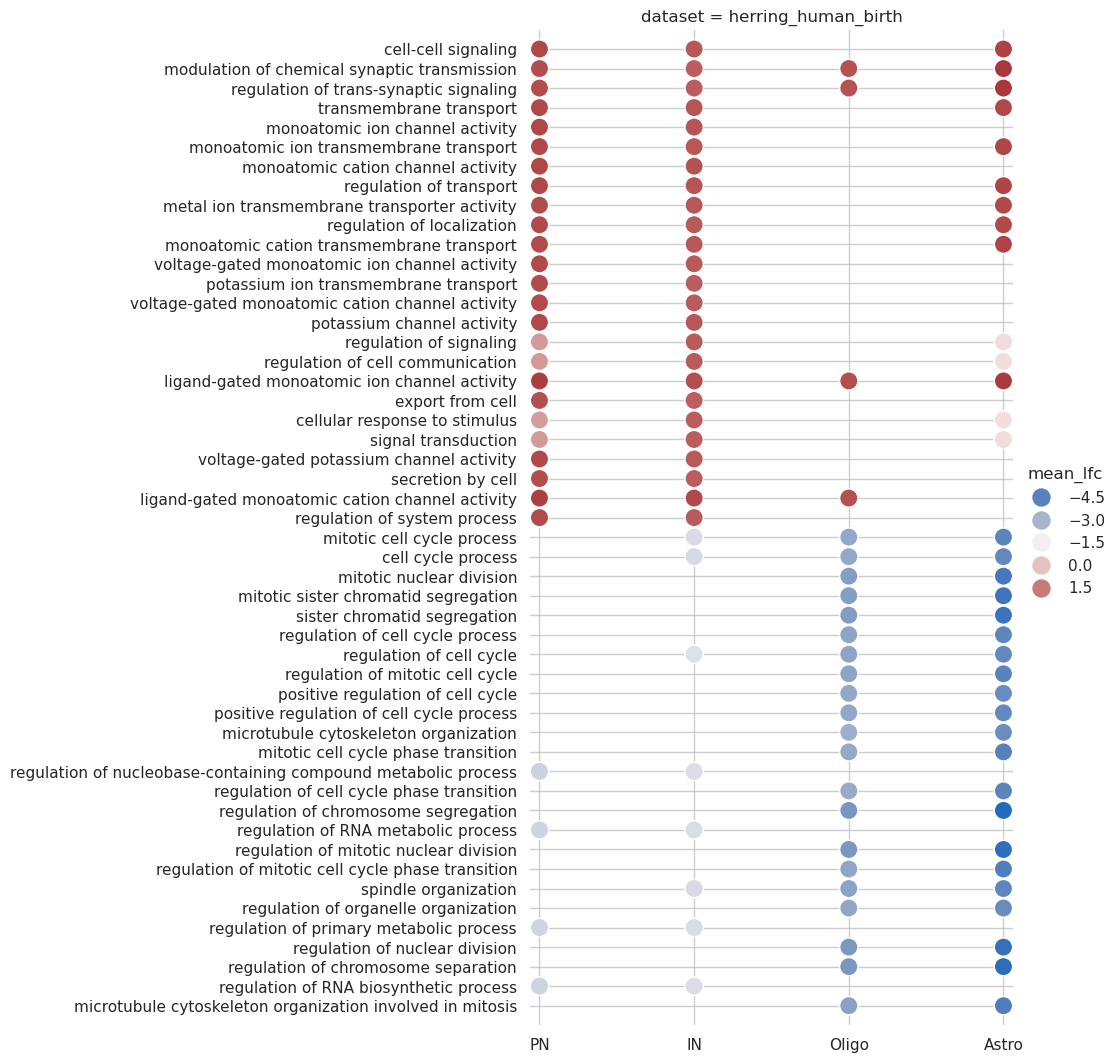

In [17]:
sns.set_theme(style='whitegrid')
g = sns.relplot(data=dotplot_df, x='cell_type', y='go_name', hue='mean_lfc',
                palette='vlag', height=11, aspect=1, s=175, col='dataset',
                facet_kws={'legend_out': True})
g.despine(left=True, bottom=True)
g.ax.margins(0.02)
g.set(xlabel='', ylabel='')

In [18]:
# Add data from Sepp datasets
def add_to_dotplot_df(path, comp, dotplot_df, dataset, species, time_point):
    cell_types = ['PN', 'IN', 'Oligo', 'Astro']
    dges = {}
    go = {}
    for cell_type in cell_types: # Get all relevant DGE results
        try:
            dges[cell_type] = pd.read_csv(str(path+comp+cell_type), index_col=0)
        except:
            continue
        # Try/except blocks are necessary because we may not have a particular cell type for some comparisons
        # Additionally, there may not be any GO results for certain cell types because we required significant DEGs with
        #    a LFC cutoff of 1, so some comparisons had no passing genes
        try:
            go_up = pd.read_csv(str(path+'go_results/all_genes/go_up_'+comp+cell_type), index_col=0).dropna()
        except:
            go_up = None
        try:
            go_down = pd.read_csv(str(path+'go_results/all_genes/go_down_'+comp+cell_type), index_col=0).dropna()
        except:
            go_down = None
        try:
            go_combined = pd.concat([go_up, go_down])
            go[cell_type] = go_combined
        except:
            continue
    for cell_type, dge in dges.items():
        for i in most_enriched.index:
            term = most_enriched.loc[i]
            # Get list of intersecting genes for term
            if cell_type not in go.keys():
                continue
            intersections = go[cell_type][go[cell_type]['native'] == term['native']]['intersections']
            gene_list = []
            for l in intersections:
                gene_list = gene_list + ast.literal_eval(l)
            # Gene list now contains all DEGs for this cell type associated with the current GO term
            # Get expression data for relevant genes from DEG result
            if len(gene_list) > 0:
                gene_data = dges[cell_type].loc[gene_list]
                mean_lfc = stats.mean(gene_data['log2FoldChange'])
            else:
                mean_lfc = np.nan
            dotplot_df.loc[len(dotplot_df)] = [str(dataset+'_'+species+'_'+time_point), cell_type, term['native'], 
                                               term['name'], len(gene_list), mean_lfc]
    return dotplot_df

In [19]:
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/human/stagewise/cell_type_split/'
comp = 'sepp_human_infancy_fetal_'
sepp_human_dotplot_df = add_to_dotplot_df(path, comp, dotplot_df.copy(), 'sepp', 'human', 'birth')
sepp_human_dotplot_df

dataset cell_type       go_id  \
0    herring_human_birth        PN  GO:0007267   
1    herring_human_birth        PN  GO:0050804   
2    herring_human_birth        PN  GO:0099177   
3    herring_human_birth        PN  GO:0055085   
4    herring_human_birth        PN  GO:0005216   
..                   ...       ...         ...   
395     sepp_human_birth     Astro  GO:0080090   
396     sepp_human_birth     Astro  GO:0051783   
397     sepp_human_birth     Astro  GO:1905818   
398     sepp_human_birth     Astro  GO:2001141   
399     sepp_human_birth     Astro  GO:1902850   

                                               go_name  num_genes  mean_lfc  
0                                  cell-cell signaling        189  2.611304  
1         modulation of chemical synaptic transmission         90  2.478915  
2               regulation of trans-synaptic signaling         90  2.478915  
3                              transmembrane transport        176  2.567066  
4                      monoatomic ion channel activity         84  2.604813  
..                                                 ...        ...       ...  
395            regulation of primary metabolic process        216 -2.701513  
396                     regulation of nuclear division         18 -3.815181  
397                regulation of chromosome separation         14 -3.911495  
398             regulation of RNA biosynthetic process        131 -2.746114  
399  microtubule cytoskeleton organization involved...         18 -3.128059  

[400 rows x 6 columns]

In [20]:
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/stagewise/cell_type_split/'
comp = 'sepp_mouse_infancy_fetal_early_'
sepp_mouse_dotplot_df = add_to_dotplot_df(path, comp, sepp_human_dotplot_df.copy(), 'sepp', 'mouse', 'birth')
sepp_mouse_dotplot_df

dataset cell_type       go_id  \
0    herring_human_birth        PN  GO:0007267   
1    herring_human_birth        PN  GO:0050804   
2    herring_human_birth        PN  GO:0099177   
3    herring_human_birth        PN  GO:0055085   
4    herring_human_birth        PN  GO:0005216   
..                   ...       ...         ...   
495     sepp_mouse_birth        IN  GO:0080090   
496     sepp_mouse_birth        IN  GO:0051783   
497     sepp_mouse_birth        IN  GO:1905818   
498     sepp_mouse_birth        IN  GO:2001141   
499     sepp_mouse_birth        IN  GO:1902850   

                                               go_name  num_genes  mean_lfc  
0                                  cell-cell signaling        189  2.611304  
1         modulation of chemical synaptic transmission         90  2.478915  
2               regulation of trans-synaptic signaling         90  2.478915  
3                              transmembrane transport        176  2.567066  
4                      monoatomic ion channel activity         84  2.604813  
..                                                 ...        ...       ...  
495            regulation of primary metabolic process        251 -2.861535  
496                     regulation of nuclear division          0       NaN  
497                regulation of chromosome separation          0       NaN  
498             regulation of RNA biosynthetic process        170 -3.069722  
499  microtubule cytoskeleton organization involved...          0       NaN  

[500 rows x 6 columns]

In [21]:
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/cell_type_split/'
comp = 'sepp_opossum_neonatal_late_early_'
sepp_opossum_dotplot_df = add_to_dotplot_df(path, comp, sepp_mouse_dotplot_df.copy(), 'sepp', 'opossum', 'neonatal')
sepp_opossum_dotplot_df

dataset cell_type       go_id  \
0      herring_human_birth        PN  GO:0007267   
1      herring_human_birth        PN  GO:0050804   
2      herring_human_birth        PN  GO:0099177   
3      herring_human_birth        PN  GO:0055085   
4      herring_human_birth        PN  GO:0005216   
..                     ...       ...         ...   
645  sepp_opossum_neonatal     Astro  GO:0080090   
646  sepp_opossum_neonatal     Astro  GO:0051783   
647  sepp_opossum_neonatal     Astro  GO:1905818   
648  sepp_opossum_neonatal     Astro  GO:2001141   
649  sepp_opossum_neonatal     Astro  GO:1902850   

                                               go_name  num_genes  mean_lfc  
0                                  cell-cell signaling        189  2.611304  
1         modulation of chemical synaptic transmission         90  2.478915  
2               regulation of trans-synaptic signaling         90  2.478915  
3                              transmembrane transport        176  2.567066  
4                      monoatomic ion channel activity         84  2.604813  
..                                                 ...        ...       ...  
645            regulation of primary metabolic process          0       NaN  
646                     regulation of nuclear division          9 -1.346130  
647                regulation of chromosome separation          9 -1.308210  
648             regulation of RNA biosynthetic process          0       NaN  
649  microtubule cytoskeleton organization involved...         16 -1.341872  

[650 rows x 6 columns]

In [22]:
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/cell_type_split/'
comp = 'sepp_opossum_adolescence_infancy_'
sepp_opossum2_dotplot_df = add_to_dotplot_df(path, comp, sepp_opossum_dotplot_df.copy(), 'sepp', 'opossum', 'eye_opening')
sepp_opossum2_dotplot_df

dataset cell_type       go_id  \
0         herring_human_birth        PN  GO:0007267   
1         herring_human_birth        PN  GO:0050804   
2         herring_human_birth        PN  GO:0099177   
3         herring_human_birth        PN  GO:0055085   
4         herring_human_birth        PN  GO:0005216   
..                        ...       ...         ...   
845  sepp_opossum_eye_opening     Astro  GO:0080090   
846  sepp_opossum_eye_opening     Astro  GO:0051783   
847  sepp_opossum_eye_opening     Astro  GO:1905818   
848  sepp_opossum_eye_opening     Astro  GO:2001141   
849  sepp_opossum_eye_opening     Astro  GO:1902850   

                                               go_name  num_genes  mean_lfc  
0                                  cell-cell signaling        189  2.611304  
1         modulation of chemical synaptic transmission         90  2.478915  
2               regulation of trans-synaptic signaling         90  2.478915  
3                              transmembrane transport        176  2.567066  
4                      monoatomic ion channel activity         84  2.604813  
..                                                 ...        ...       ...  
845            regulation of primary metabolic process          0       NaN  
846                     regulation of nuclear division          0       NaN  
847                regulation of chromosome separation          0       NaN  
848             regulation of RNA biosynthetic process          0       NaN  
849  microtubule cytoskeleton organization involved...          0       NaN  

[850 rows x 6 columns]

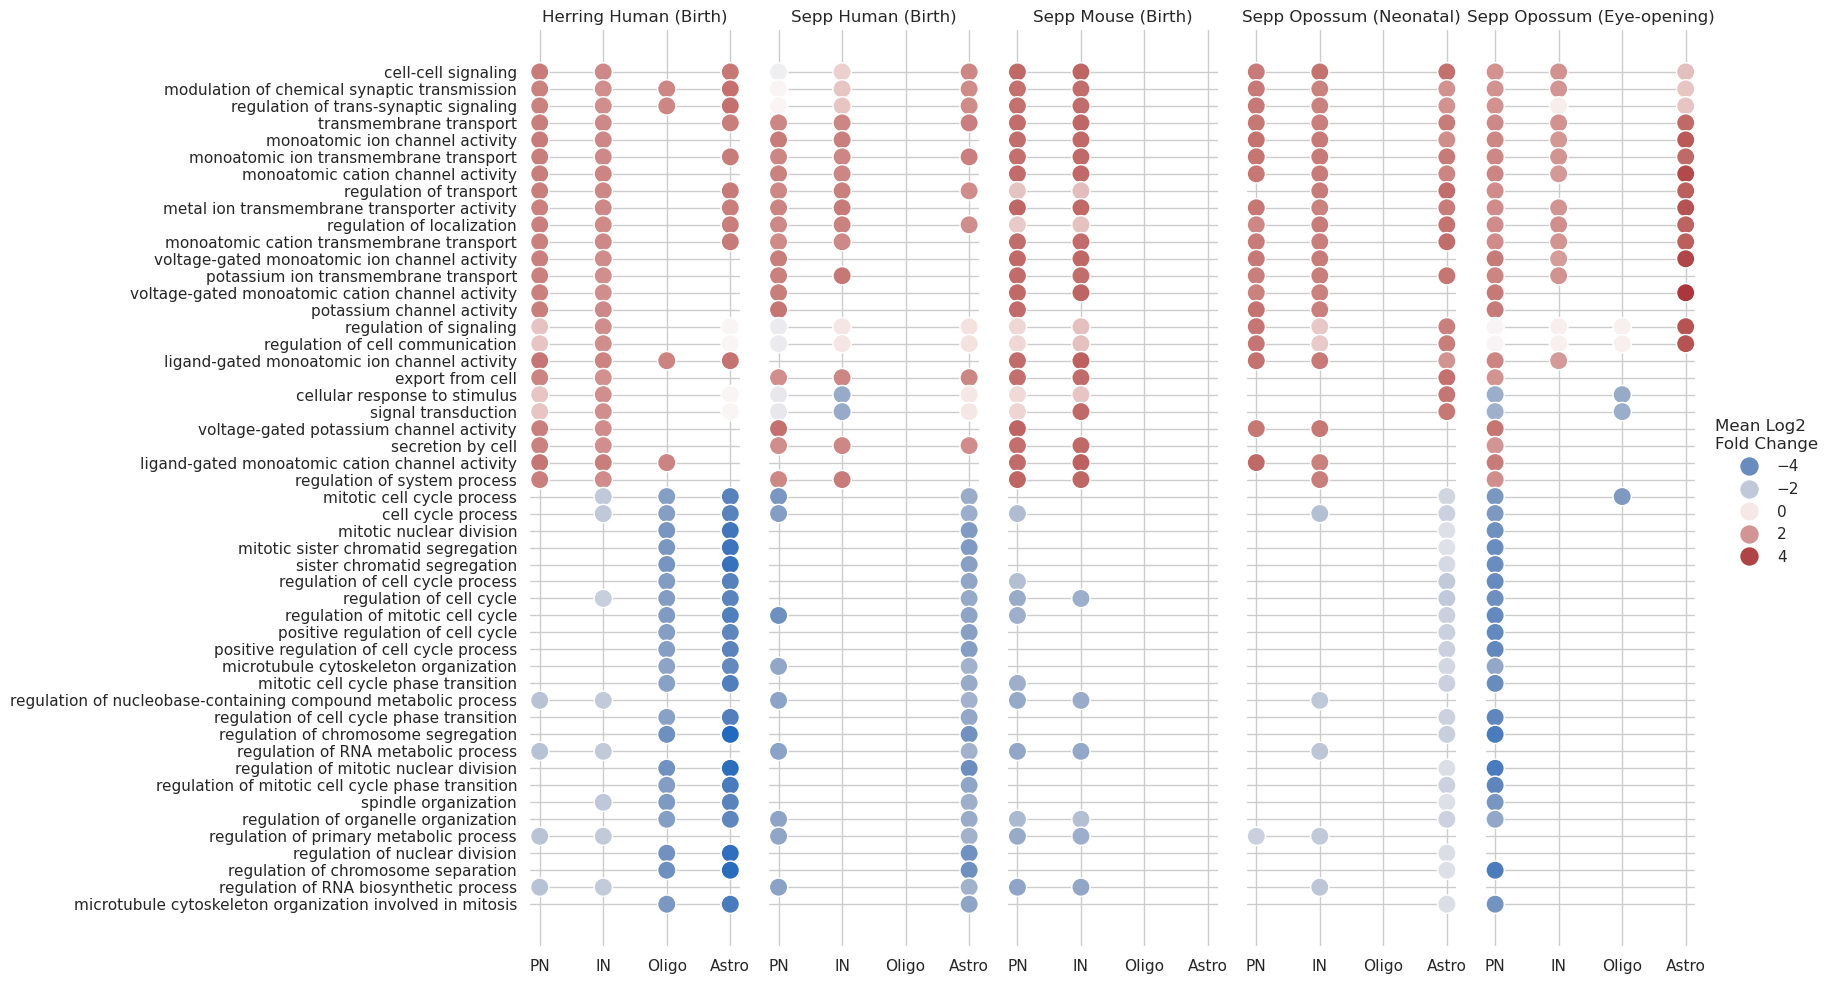

In [23]:
sns.set_theme(style='whitegrid')
g = sns.relplot(data=sepp_opossum2_dotplot_df, x='cell_type', y='go_name', hue='mean_lfc',
                palette='vlag', height=10, aspect=0.35, s=175, col='dataset')
g.despine(left=True, bottom=True)
g.set(xlabel='', ylabel='')
axes=g.axes.flatten()
axes[0].set_title('Herring Human (Birth)')
axes[1].set_title('Sepp Human (Birth)')
axes[2].set_title('Sepp Mouse (Birth)')
axes[3].set_title('Sepp Opossum (Neonatal)')
axes[4].set_title('Sepp Opossum (Eye-opening)')
g.legend.set_title('Mean Log2\nFold Change')
g.tight_layout()
g.savefig(str(FIG_PATH+'go_term_dotplot.svg'), dpi=300, bbox_inches='tight') 

In general, for the top 25 most enriched up- and down- regulated GO terms from the Herring dataset across all broad cell types, the up-regulated terms tend to be those related to setting up functional gene networks while the down-regulated terms tend to be those associated with tissue development, cell proliferation. Down regulated terms are strongest in the non-neuronal groups in human samples. Up-regulated terms seem to match best with the non-human samples closer to birth, whereas down-regulated terms seem to match best in the eye-opening comparison in opossum.\
\
This approach seems flawed because it doesn't represent the similarities between samples very well - looking for overlaps like this fails to capture terms that are biologically similar because it requires them to be exactly the same. A simple table of the 25 most up and down regulated terms from each group may actually show the comparisons a bit more clearly.\
\
Check most enriched specifically in human neuronal cells and non-human samples to see if there's something else being down regulated in those groups.

In [24]:
def check_enrichment(path, comp, cell_types):
    # Read in all cell type split GO results for a given comparison
    upreg = []
    downreg = []
    prefixes = ['go_up_', 'go_down_']
    for prefix in prefixes:
        for cell_type in cell_types:
            res = pd.read_csv(str(path+prefix+comp+cell_type), index_col=0)
            if prefix == 'go_up_':
                upreg.append(res)
            elif prefix == 'go_down_':
                downreg.append(res)
    # Generate list of most enriched terms for each result, remove any terms that appear in both the up and down regulated lists
    most_enriched_up = pd.DataFrame(columns=['source', 'native', 'name'])
    most_enriched_down = pd.DataFrame(columns=['source', 'native', 'name'])
    for up, down in zip(upreg, downreg):
        # Get only the GO terms which are not also in the opposite results for the same cell type - i.e. those that are 
        #    uniquely up- or down-regulated
        unique_up = up[up['source'].isin(['GO:BP', 'GO:MF', 'KEGG', 'REAC', 'WP'])].sort_values(by='p_value')[['source', 'native', 'name', 'parents']]
        unique_up_ids = [g for g in unique_up['native'].values if g not in down['native'].values]
        unique_up = up[up['native'].isin(unique_up_ids)]
        unique_up = unique_up.loc[[True if len(ast.literal_eval(p)) >= 2 else False for p in unique_up['parents'].values]]
        most_enriched_up = pd.concat([most_enriched_up, unique_up]).drop_duplicates()
        unique_down = down[down['source'].isin(['GO:BP', 'GO:MF', 'KEGG', 'REAC', 'WP'])].sort_values(by='p_value')[['source', 'native', 'name', 'parents']]
        unique_down_ids = [g for g in unique_down['native'].values if g not in up['native'].values]
        unique_down = down[down['native'].isin(unique_down_ids)]
        unique_down = unique_down.loc[[True if len(ast.literal_eval(p)) >= 2 else False for p in unique_down['parents'].values]]
        most_enriched_down = pd.concat([most_enriched_down, unique_down]).drop_duplicates()
    most_enriched_up.reset_index(inplace=True, drop=True)
    most_enriched_up = most_enriched_up.sort_values(by='p_value')
    up = pd.DataFrame(columns=['source', 'native', 'name'])
    for i in range(0, len(most_enriched_up)):
        if len(up) >= 25:
            break
        term = most_enriched_up.iloc[i]
        if term['native'] in up['native'].values:
            continue
        else:
            up.loc[len(up)] = term[['source', 'native', 'name']]
    most_enriched_down.reset_index(inplace=True, drop=True)
    most_enriched_down = most_enriched_down.sort_values(by='p_value')
    down = pd.DataFrame(columns=['source', 'native', 'name'])
    for i in range(0, len(most_enriched_down)):
        if len(down) >= 25:
            break
        term = most_enriched_down.iloc[i]
        if term['native'] in down['native'].values:
            continue
        else:
            down.loc[len(down)] = term[['source', 'native', 'name']]
    return {'up': up, 'down': down}

In [25]:
path = '/group/ll005/cmcphan/notebooks/analysis/results/herring/stagewise/cell_type_split/go_results/all_genes/'
comp = 'herring_infancy_fetal_'
cell_types = ['PN', 'IN']
check_enrichment(path, comp, cell_types)['down']

source      native                                               name
0   GO:BP  GO:0019219  regulation of nucleobase-containing compound m...
1   GO:BP  GO:0051252                regulation of RNA metabolic process
2   GO:BP  GO:0080090            regulation of primary metabolic process
3   GO:BP  GO:2001141             regulation of RNA biosynthetic process
4   GO:BP  GO:0006355          regulation of DNA-templated transcription
5   GO:BP  GO:0006351                        DNA-templated transcription
6   GO:BP  GO:0006357   regulation of transcription by RNA polymerase II
7   GO:BP  GO:0030900                              forebrain development
8   GO:BP  GO:0021537                          telencephalon development
9   GO:BP  GO:0019222                    regulation of metabolic process
10  GO:BP  GO:0007420                                  brain development
11  GO:BP  GO:0060255      regulation of macromolecule metabolic process
12  GO:BP  GO:0048523            negative regulation of cellular process
13  GO:BP  GO:0045934  negative regulation of nucleobase-containing c...
14  GO:BP  GO:0045935  positive regulation of nucleobase-containing c...
15  GO:BP  GO:0051253       negative regulation of RNA metabolic process
16  GO:BP  GO:0009889                 regulation of biosynthetic process
17  GO:BP  GO:0010468                      regulation of gene expression
18  GO:BP  GO:0045892  negative regulation of DNA-templated transcrip...
19  GO:BP  GO:0021543                                pallium development
20  GO:BP  GO:0048519          negative regulation of biological process
21  GO:BP  GO:1902679    negative regulation of RNA biosynthetic process
22  GO:BP  GO:0010556   regulation of macromolecule biosynthetic process
23  GO:BP  GO:0051254       positive regulation of RNA metabolic process
24  GO:BP  GO:0009893           positive regulation of metabolic process

In [26]:
path = '/group/ll005/cmcphan/notebooks/analysis/results/herring/stagewise/cell_type_split/go_results/all_genes/'
comp = 'herring_infancy_fetal_'
cell_types = ['IN']
check_enrichment(path, comp, cell_types)['down']

source      native                                               name
0   GO:BP  GO:0019219  regulation of nucleobase-containing compound m...
1   GO:BP  GO:0051252                regulation of RNA metabolic process
2   GO:BP  GO:0080090            regulation of primary metabolic process
3   GO:BP  GO:2001141             regulation of RNA biosynthetic process
4   GO:BP  GO:0006355          regulation of DNA-templated transcription
5   GO:BP  GO:0006351                        DNA-templated transcription
6   GO:BP  GO:0006357   regulation of transcription by RNA polymerase II
7   GO:BP  GO:0030900                              forebrain development
8   GO:BP  GO:0021537                          telencephalon development
9   GO:BP  GO:0019222                    regulation of metabolic process
10  GO:BP  GO:0007420                                  brain development
11  GO:BP  GO:0060255      regulation of macromolecule metabolic process
12  GO:BP  GO:0048523            negative regulation of cellular process
13  GO:BP  GO:0045934  negative regulation of nucleobase-containing c...
14  GO:BP  GO:0045935  positive regulation of nucleobase-containing c...
15  GO:BP  GO:0051253       negative regulation of RNA metabolic process
16  GO:BP  GO:0009889                 regulation of biosynthetic process
17  GO:BP  GO:0010468                      regulation of gene expression
18  GO:BP  GO:0045892  negative regulation of DNA-templated transcrip...
19  GO:BP  GO:0021543                                pallium development
20  GO:BP  GO:0048519          negative regulation of biological process
21  GO:BP  GO:1902679    negative regulation of RNA biosynthetic process
22  GO:BP  GO:0010556   regulation of macromolecule biosynthetic process
23  GO:BP  GO:0051254       positive regulation of RNA metabolic process
24  GO:BP  GO:0009893           positive regulation of metabolic process

In [27]:
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/human/stagewise/cell_type_split/go_results/all_genes/'
comp = 'sepp_human_infancy_fetal_'
cell_types = ['PN', 'IN']
check_enrichment(path, comp, cell_types)['down']

source      native                                               name
0   GO:BP  GO:0048468                                   cell development
1   GO:BP  GO:0050793                regulation of developmental process
2   GO:BP  GO:0007409                                       axonogenesis
3   GO:BP  GO:0048858                      cell projection morphogenesis
4   GO:BP  GO:0048667  cell morphogenesis involved in neuron differen...
5   GO:BP  GO:0048812                    neuron projection morphogenesis
6   GO:BP  GO:2000026  regulation of multicellular organismal develop...
7   GO:BP  GO:0051960           regulation of nervous system development
8   GO:BP  GO:0051094       positive regulation of developmental process
9   GO:BP  GO:0007417                 central nervous system development
10  GO:BP  GO:0045595                 regulation of cell differentiation
11  GO:BP  GO:0051962  positive regulation of nervous system development
12  GO:BP  GO:0048519          negative regulation of biological process
13  GO:BP  GO:0007420                                  brain development
14  GO:BP  GO:0048523            negative regulation of cellular process
15  GO:BP  GO:0097485                         neuron projection guidance
16  GO:BP  GO:0007411                                      axon guidance
17  GO:BP  GO:0031346  positive regulation of cell projection organiz...
18  GO:BP  GO:0050767                         regulation of neurogenesis
19  GO:BP  GO:0009653                 anatomical structure morphogenesis
20  GO:BP  GO:0051130  positive regulation of cellular component orga...
21  GO:BP  GO:0045597        positive regulation of cell differentiation
22  GO:BP  GO:0009887                         animal organ morphogenesis
23  GO:BP  GO:0030900                              forebrain development
24  GO:BP  GO:0060284                     regulation of cell development

Similar sorts of terms being downregulated, though the specific terms present are different, hence the lower presence of these terms in the figure above.

In [28]:
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/stagewise/cell_type_split/go_results/all_genes/'
comp = 'sepp_mouse_infancy_fetal_early_'
cell_types = ['PN', 'IN']
check_enrichment(path, comp, cell_types)['down']

source      native                                               name
0   GO:BP  GO:0080090            regulation of primary metabolic process
1   GO:BP  GO:0019222                    regulation of metabolic process
2   GO:BP  GO:0060255      regulation of macromolecule metabolic process
3   GO:BP  GO:0010556   regulation of macromolecule biosynthetic process
4   GO:BP  GO:0019219  regulation of nucleobase-containing compound m...
5   GO:BP  GO:0009889                 regulation of biosynthetic process
6   GO:BP  GO:0006357   regulation of transcription by RNA polymerase II
7   GO:BP  GO:0009891        positive regulation of biosynthetic process
8   GO:BP  GO:0051252                regulation of RNA metabolic process
9   GO:BP  GO:0010468                      regulation of gene expression
10  GO:BP  GO:0010557  positive regulation of macromolecule biosynthe...
11  GO:BP  GO:0010604  positive regulation of macromolecule metabolic...
12  GO:BP  GO:0006351                        DNA-templated transcription
13  GO:BP  GO:0048523            negative regulation of cellular process
14  GO:BP  GO:0009893           positive regulation of metabolic process
15  GO:BP  GO:0045935  positive regulation of nucleobase-containing c...
16  GO:BP  GO:0006355          regulation of DNA-templated transcription
17  GO:BP  GO:2001141             regulation of RNA biosynthetic process
18  GO:BP  GO:0048519          negative regulation of biological process
19  GO:BP  GO:0007417                 central nervous system development
20  GO:BP  GO:0045595                 regulation of cell differentiation
21  GO:BP  GO:0045893  positive regulation of DNA-templated transcrip...
22  GO:BP  GO:1902680    positive regulation of RNA biosynthetic process
23  GO:BP  GO:0051254       positive regulation of RNA metabolic process
24  GO:BP  GO:0051253       negative regulation of RNA metabolic process

Down-regulated terms in mouse at birth seem much more focussed on regulation of a variety of metabolic and cellular processes, rather than on cell proliferation and development

In [29]:
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/cell_type_split/go_results/all_genes/'
comp = 'sepp_opossum_neonatal_late_early_'
cell_types = ['PN', 'IN']
check_enrichment(path, comp, cell_types)['down']

source      native                                               name
0   GO:BP  GO:0048523            negative regulation of cellular process
1   GO:BP  GO:0048519          negative regulation of biological process
2   GO:MF  GO:0000976        transcription cis-regulatory region binding
3   GO:MF  GO:1990837      sequence-specific double-stranded DNA binding
4   GO:BP  GO:0048522            positive regulation of cellular process
5   GO:BP  GO:0048518          positive regulation of biological process
6   GO:BP  GO:0006357   regulation of transcription by RNA polymerase II
7   GO:BP  GO:0007417                 central nervous system development
8   GO:BP  GO:0000122  negative regulation of transcription by RNA po...
9   GO:BP  GO:0051253       negative regulation of RNA metabolic process
10  GO:BP  GO:0045892  negative regulation of DNA-templated transcrip...
11  GO:BP  GO:0045934  negative regulation of nucleobase-containing c...
12  GO:BP  GO:1902679    negative regulation of RNA biosynthetic process
13  GO:MF  GO:0000978  RNA polymerase II cis-regulatory region sequen...
14  GO:BP  GO:0080090            regulation of primary metabolic process
15  GO:BP  GO:0010604  positive regulation of macromolecule metabolic...
16  GO:BP  GO:0009893           positive regulation of metabolic process
17  GO:BP  GO:0045595                 regulation of cell differentiation
18  GO:BP  GO:0007420                                  brain development
19  GO:BP  GO:0019222                    regulation of metabolic process
20  GO:BP  GO:0009892           negative regulation of metabolic process
21  GO:BP  GO:0010557  positive regulation of macromolecule biosynthe...
22  GO:BP  GO:0045944  positive regulation of transcription by RNA po...
23  GO:BP  GO:0072009                     nephron epithelium development
24  GO:BP  GO:0035295                                   tube development

Similar to mouse at birth, opossum just after birth seems to be more focussed on downregulating regulators of biological processes

In [30]:
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/cell_type_split/go_results/all_genes/'
comp = 'sepp_opossum_adolescence_infancy_'
cell_types = ['PN', 'IN']
check_enrichment(path, comp, cell_types)['down']

source      native                                               name
0   GO:BP  GO:0022402                                 cell cycle process
1   GO:BP  GO:1903047                         mitotic cell cycle process
2   GO:BP  GO:0048523            negative regulation of cellular process
3   GO:BP  GO:0048519          negative regulation of biological process
4   GO:BP  GO:0048468                                   cell development
5   GO:BP  GO:0000819                       sister chromatid segregation
6   GO:BP  GO:0140014                           mitotic nuclear division
7   GO:BP  GO:0009966                  regulation of signal transduction
8   GO:BP  GO:0048812                    neuron projection morphogenesis
9   GO:BP  GO:0007411                                      axon guidance
10  GO:BP  GO:0097485                         neuron projection guidance
11  GO:BP  GO:0048858                      cell projection morphogenesis
12  GO:BP  GO:0009653                 anatomical structure morphogenesis
13  GO:BP  GO:0048667  cell morphogenesis involved in neuron differen...
14  GO:BP  GO:0022008                                       neurogenesis
15  GO:BP  GO:0000070               mitotic sister chromatid segregation
16  GO:BP  GO:0051128      regulation of cellular component organization
17  GO:BP  GO:0030182                             neuron differentiation
18  GO:BP  GO:0050789                   regulation of biological process
19  GO:BP  GO:0045595                 regulation of cell differentiation
20  GO:BP  GO:0007409                                       axonogenesis
21  GO:BP  GO:0050794                     regulation of cellular process
22  GO:BP  GO:0048666                                 neuron development
23  GO:BP  GO:0048583                 regulation of response to stimulus
24  GO:BP  GO:0010975        regulation of neuron projection development

Around eye opening we see more of the cell proliferation terms, suggesting that perhaps the changes at birth in humans and eye-opening in opossum are more similar

In [31]:
paths = ['/group/ll005/cmcphan/notebooks/analysis/results/herring/stagewise/cell_type_split/go_results/all_genes/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/human/stagewise/cell_type_split/go_results/all_genes/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/stagewise/cell_type_split/go_results/all_genes/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/cell_type_split/go_results/all_genes/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/cell_type_split/go_results/all_genes/']
comps = ['herring_infancy_fetal_', 'sepp_human_infancy_fetal_', 'sepp_mouse_infancy_fetal_early_', 
         'sepp_opossum_infancy_neonatal_late_', 'sepp_opossum_adolescence_infancy_']
cell_types = ['PN', 'IN']
summary = pd.DataFrame()
directions = list(['up']*25 + ['down']*25)
summary['direction'] = directions
for path, comp in zip(paths, comps):
    enriched = check_enrichment(path, comp, cell_types)
    top_up = enriched['up']['name'].values.tolist()[:25]
    top_down = enriched['down']['name'].values.tolist()[:25]
    summary[comp[:-1]] = list(top_up + top_down)
summary.to_csv(str('/group/ll005/cmcphan/notebooks/analysis/results/'+'go_terms_results_summary.csv'))
summary

direction                              herring_infancy_fetal  \
0         up                                cell-cell signaling   
1         up       modulation of chemical synaptic transmission   
2         up             regulation of trans-synaptic signaling   
3         up                            transmembrane transport   
4         up                    monoatomic ion channel activity   
5         up             monoatomic ion transmembrane transport   
6         up                 monoatomic cation channel activity   
7         up                            regulation of transport   
8         up       metal ion transmembrane transporter activity   
9         up                         regulation of localization   
10        up          monoatomic cation transmembrane transport   
11        up      voltage-gated monoatomic ion channel activity   
12        up              potassium ion transmembrane transport   
13        up   voltage-gated monoatomic cation channel activity   
14        up                         potassium channel activity   
15        up                            regulation of signaling   
16        up                   regulation of cell communication   
17        up       ligand-gated monoatomic ion channel activity   
18        up                                   export from cell   
19        up                      cellular response to stimulus   
20        up                                signal transduction   
21        up           voltage-gated potassium channel activity   
22        up                                  secretion by cell   
23        up    ligand-gated monoatomic cation channel activity   
24        up                       regulation of system process   
25      down  regulation of nucleobase-containing compound m...   
26      down                regulation of RNA metabolic process   
27      down            regulation of primary metabolic process   
28      down             regulation of RNA biosynthetic process   
29      down          regulation of DNA-templated transcription   
30      down                        DNA-templated transcription   
31      down   regulation of transcription by RNA polymerase II   
32      down                              forebrain development   
33      down                          telencephalon development   
34      down                    regulation of metabolic process   
35      down                                  brain development   
36      down      regulation of macromolecule metabolic process   
37      down            negative regulation of cellular process   
38      down  negative regulation of nucleobase-containing c...   
39      down  positive regulation of nucleobase-containing c...   
40      down       negative regulation of RNA metabolic process   
41      down                 regulation of biosynthetic process   
42      down                      regulation of gene expression   
43      down  negative regulation of DNA-templated transcrip...   
44      down                                pallium development   
45      down          negative regulation of biological process   
46      down    negative regulation of RNA biosynthetic process   
47      down   regulation of macromolecule biosynthetic process   
48      down       positive regulation of RNA metabolic process   
49      down           positive regulation of metabolic process   

                             sepp_human_infancy_fetal  \
0                             regulation of transport   
1              monoatomic ion transmembrane transport   
2           monoatomic cation transmembrane transport   
3                              synaptic vesicle cycle   
4                          regulation of localization   
5                             transmembrane transport   
6                   regulation of synaptic plasticity   
7   regulation of monoatomic ion transmembrane tra...   
8              regulation of monoatomic ion transport   
9              

Since the downregulated terms in the non-neuronal groups seem to dominate and they don't match up well across datasets because of the lack of non-neuronal types in the Sepp data, exclude them from the analysis. We're more interested in the neurons anyway.

In [142]:
herring_upreg = []
herring_downreg = []
path = '/group/ll005/cmcphan/notebooks/analysis/results/herring/stagewise/cell_type_split/go_results/all_genes/'
comp = 'herring_infancy_fetal_'
cell_types = ['PN', 'IN'] # Ignore non-neu group as it is made up of the oligo and astro groups
prefixes = ['go_up_', 'go_down_']
for prefix in prefixes:
    for cell_type in cell_types:
        res = pd.read_csv(str(path+prefix+comp+cell_type), index_col=0)
        if prefix == 'go_up_':
            herring_upreg.append(res)
        elif prefix == 'go_down_':
            herring_downreg.append(res)
# Generate list of most enriched terms for each result, remove any terms that appear in both the up and down regulated lists
most_enriched_up = pd.DataFrame(columns=['source', 'native', 'name'])
most_enriched_down = pd.DataFrame(columns=['source', 'native', 'name'])
for up, down in zip(herring_upreg, herring_downreg):
    # Get only the GO terms which are not also in the opposite results for the same cell type - i.e. those that are 
    #    uniquely up- or down-regulated
    unique_up = up[up['source'].isin(['GO:BP', 'GO:MF', 'KEGG', 'REAC', 'WP'])].sort_values(by='p_value')[['source', 'native', 'name', 'parents']]
    unique_up_ids = [g for g in unique_up['native'].values if g not in down['native'].values]
    unique_up = up[up['native'].isin(unique_up_ids)]
    unique_up = unique_up.loc[[True if len(ast.literal_eval(p)) >= 2 else False for p in unique_up['parents'].values]]
    most_enriched_up = pd.concat([most_enriched_up, unique_up]).drop_duplicates()
    unique_down = down[down['source'].isin(['GO:BP', 'GO:MF', 'KEGG', 'REAC', 'WP'])].sort_values(by='p_value')[['source', 'native', 'name', 'parents']]
    unique_down_ids = [g for g in unique_down['native'].values if g not in up['native'].values]
    unique_down = down[down['native'].isin(unique_down_ids)]
    unique_down = unique_down.loc[[True if len(ast.literal_eval(p)) >= 2 else False for p in unique_down['parents'].values]]
    most_enriched_down = pd.concat([most_enriched_down, unique_down]).drop_duplicates()
most_enriched_up.reset_index(inplace=True, drop=True)
most_enriched_up = most_enriched_up.sort_values(by='p_value')
up = pd.DataFrame(columns=['source', 'native', 'name'])
for i in range(0, len(most_enriched_up)):
    if len(up) >= 25:
        break
    term = most_enriched_up.iloc[i]
    if term['native'] in up['native'].values:
        continue
    else:
        up.loc[len(up)] = term[['source', 'native', 'name']]
most_enriched_down.reset_index(inplace=True, drop=True)
most_enriched_down = most_enriched_down.sort_values(by='p_value')
down = pd.DataFrame(columns=['source', 'native', 'name'])
for i in range(0, len(most_enriched_down)):
    if len(down) >= 25:
        break
    term = most_enriched_down.iloc[i]
    if term['native'] in down['native'].values:
        continue
    else:
        down.loc[len(down)] = term[['source', 'native', 'name']]
most_enriched = pd.concat([up, down])
most_enriched.reset_index(inplace=True, drop=True)
most_enriched.drop_duplicates()
# Combine enriched terms into a single list and compile expression data for each term in each group
dotplot_df = pd.DataFrame(columns=['dataset', 'cell_type', 'go_id', 'go_name', 'num_genes', 'mean_lfc'])
path = '/group/ll005/cmcphan/notebooks/analysis/results/herring/stagewise/cell_type_split/'
comp = 'herring_infancy_fetal_'
cell_types = ['PN', 'IN', 'Oligo', 'Astro']
herring_dges = {}
herring_go = {}
for cell_type in cell_types: # Get all relevant DGE results
    herring_dges[cell_type] = pd.read_csv(str(path+comp+cell_type), index_col=0)
    go_up = pd.read_csv(str(path+'go_results/all_genes/go_up_'+comp+cell_type), index_col=0)
    go_down = pd.read_csv(str(path+'go_results/all_genes/go_down_'+comp+cell_type), index_col=0)
    go_combined = pd.concat([go_up, go_down])
    herring_go[cell_type] = go_combined
for cell_type, dge in herring_dges.items():
    for i in most_enriched.index:
        term = most_enriched.loc[i]
        # Get list of intersecting genes for term
        intersections = herring_go[cell_type][herring_go[cell_type]['native'] == term['native']]['intersections']
        gene_list = []
        for l in intersections:
            gene_list = gene_list + ast.literal_eval(l)
        # Gene list now contains all DEGs for this cell type associated with the current GO term
        # Get expression data for relevant genes from DEG result
        if len(gene_list) > 0:
            gene_data = herring_dges[cell_type].loc[gene_list]
            mean_lfc = stats.mean(gene_data['log2FoldChange'])
        else:
            mean_lfc = np.nan
        dotplot_df.loc[len(dotplot_df)] = ['herring_human_birth', cell_type, term['native'], term['name'], len(gene_list), mean_lfc]
dotplot_df

dataset cell_type       go_id  \
0    herring_human_birth        PN  GO:0007267   
1    herring_human_birth        PN  GO:0050804   
2    herring_human_birth        PN  GO:0099177   
3    herring_human_birth        PN  GO:0055085   
4    herring_human_birth        PN  GO:0005216   
..                   ...       ...         ...   
195  herring_human_birth     Astro  GO:0048519   
196  herring_human_birth     Astro  GO:1902679   
197  herring_human_birth     Astro  GO:0010556   
198  herring_human_birth     Astro  GO:0051254   
199  herring_human_birth     Astro  GO:0009893   

                                              go_name  num_genes  mean_lfc  
0                                 cell-cell signaling        189  2.611304  
1        modulation of chemical synaptic transmission         90  2.478915  
2              regulation of trans-synaptic signaling         90  2.478915  
3                             transmembrane transport        176  2.567066  
4                     monoatomic ion channel activity         84  2.604813  
..                                                ...        ...       ...  
195         negative regulation of biological process        231 -0.763756  
196   negative regulation of RNA biosynthetic process          0       NaN  
197  regulation of macromolecule biosynthetic process          0       NaN  
198      positive regulation of RNA metabolic process          0       NaN  
199          positive regulation of metabolic process          0       NaN  

[200 rows x 6 columns]

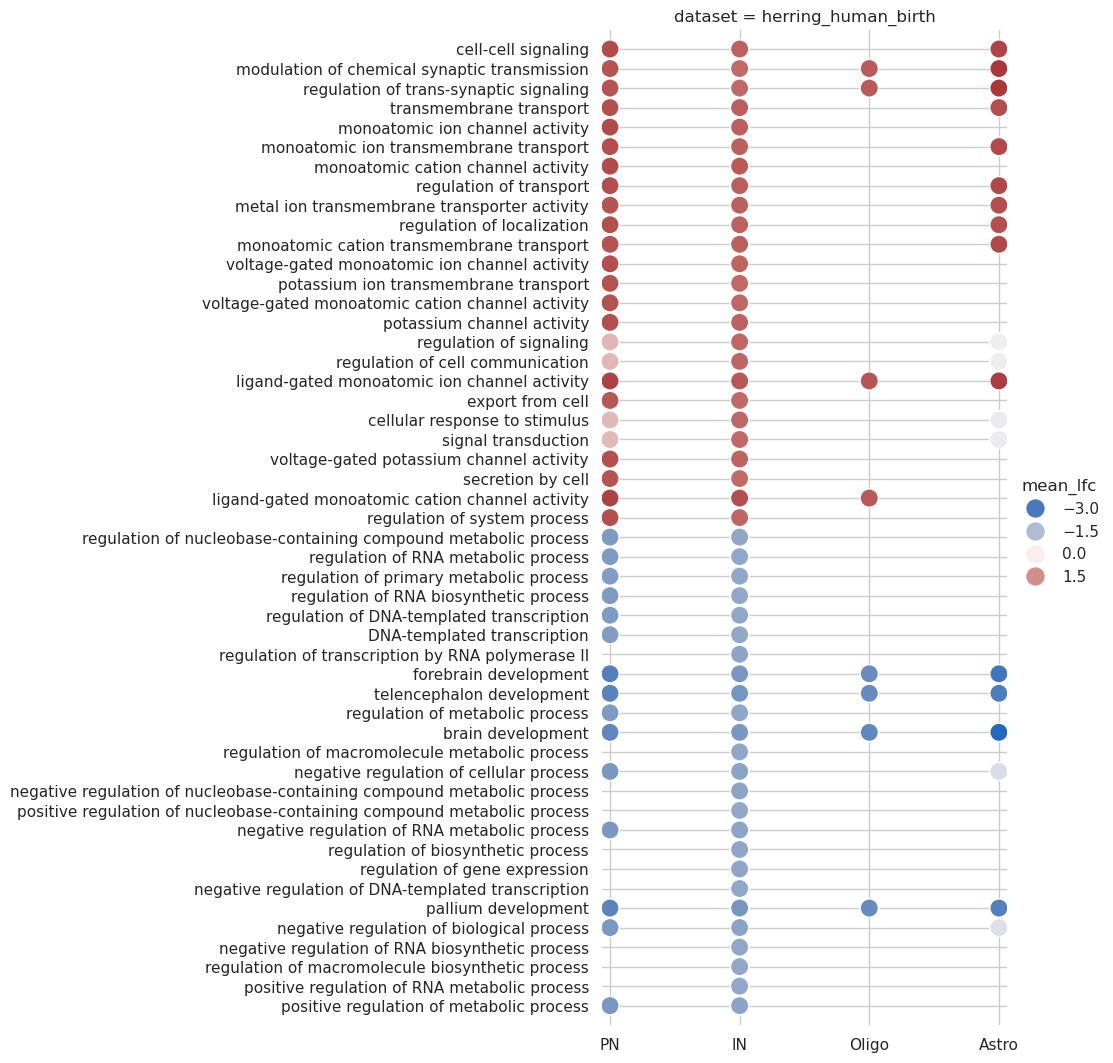

In [65]:
sns.set_theme(style='whitegrid')
g = sns.relplot(data=dotplot_df, x='cell_type', y='go_name', hue='mean_lfc',
                palette='vlag', height=11, aspect=1, s=175, col='dataset',
                facet_kws={'legend_out': True})
g.despine(left=True, bottom=True)
g.ax.margins(0.02)
g.set(xlabel='', ylabel='')

In [78]:
dotplot_df = pd.DataFrame(columns=['dataset', 'cell_type', 'go_id', 'go_name', 'num_genes', 'mean_lfc'])
path = '/group/ll005/cmcphan/notebooks/analysis/results/herring/stagewise/cell_type_split/'
comp = 'herring_infancy_fetal_'
herring_human_dotplot_df = add_to_dotplot_df(path, comp, dotplot_df.copy(), 'herring', 'human', 'birth')

In [79]:
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/human/stagewise/cell_type_split/'
comp = 'sepp_human_infancy_fetal_'
sepp_human_dotplot_df = add_to_dotplot_df(path, comp, herring_human_dotplot_df.copy(), 'sepp', 'human', 'birth')

In [80]:
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/stagewise/cell_type_split/'
comp = 'sepp_mouse_infancy_fetal_early_'
sepp_mouse_dotplot_df = add_to_dotplot_df(path, comp, sepp_human_dotplot_df.copy(), 'sepp', 'mouse', 'birth')

In [81]:
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/cell_type_split/'
comp = 'sepp_opossum_neonatal_late_early_'
sepp_opossum_dotplot_df = add_to_dotplot_df(path, comp, sepp_mouse_dotplot_df.copy(), 'sepp', 'opossum', 'neonatal')

In [82]:
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/cell_type_split/'
comp = 'sepp_opossum_adolescence_infancy_'
sepp_opossum2_dotplot_df = add_to_dotplot_df(path, comp, sepp_opossum_dotplot_df.copy(), 'sepp', 'opossum', 'eye_opening')

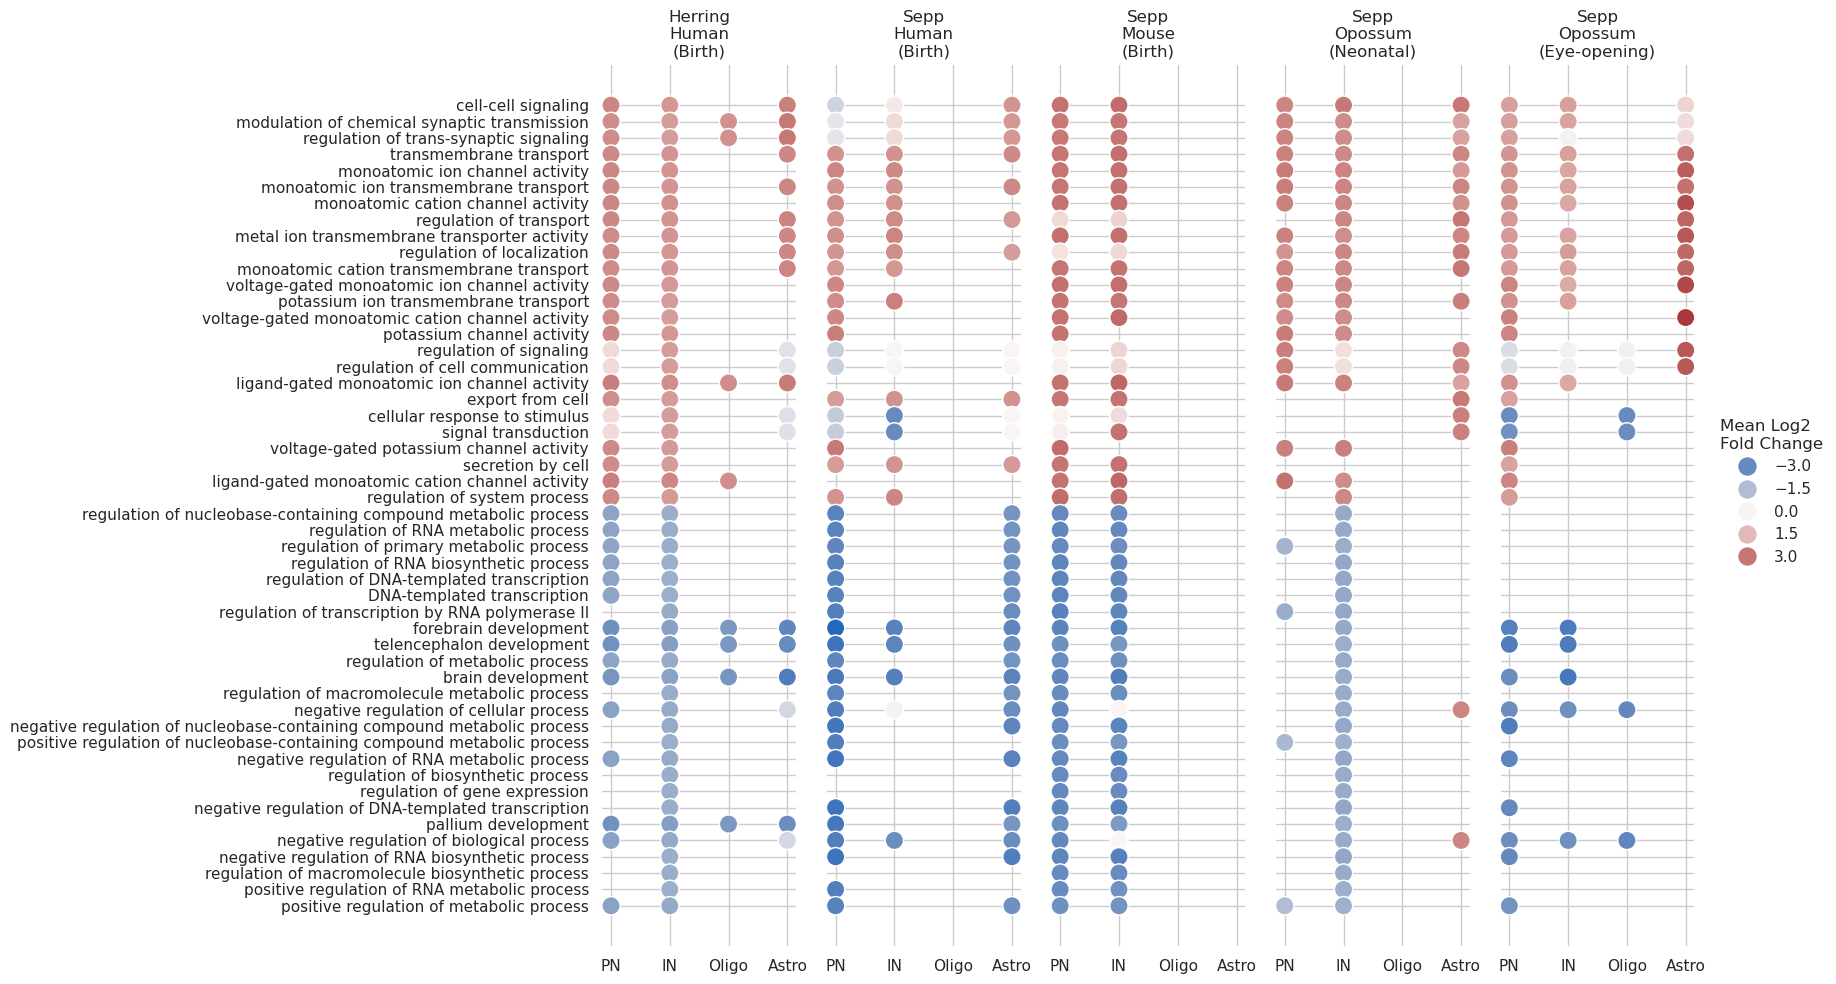

In [83]:
sns.set_theme(style='whitegrid')
g = sns.relplot(data=sepp_opossum2_dotplot_df, x='cell_type', y='go_name', hue='mean_lfc',
                palette='vlag', height=10, aspect=0.35, s=175, col='dataset')
g.despine(left=True, bottom=True)
g.set(xlabel='', ylabel='')
axes=g.axes.flatten()
axes[0].set_title('Herring\nHuman\n(Birth)')
axes[1].set_title('Sepp\nHuman\n(Birth)')
axes[2].set_title('Sepp\nMouse\n(Birth)')
axes[3].set_title('Sepp\nOpossum\n(Neonatal)')
axes[4].set_title('Sepp\nOpossum\n(Eye-opening)')
g.legend.set_title('Mean Log2\nFold Change')
g.tight_layout()
g.savefig(str(FIG_PATH+'go_term_dotplot.svg'), dpi=300, bbox_inches='tight') 

In [6]:
# Read in all cell type split GO results for a given comparison
upreg = {}
downreg = {}
paths = ['/group/ll005/cmcphan/notebooks/analysis/results/herring/stagewise/cell_type_split/go_results/all_genes/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/human/stagewise/cell_type_split/go_results/all_genes/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/stagewise/cell_type_split/go_results/all_genes/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/cell_type_split/go_results/all_genes/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/cell_type_split/go_results/all_genes/']
comps = ['herring_infancy_fetal_', 'sepp_human_infancy_fetal_', 'sepp_mouse_infancy_fetal_early_', 
         'sepp_opossum_infancy_neonatal_late_', 'sepp_opossum_adolescence_infancy_']
cell_types = ['PN', 'IN'] 
prefixes = ['go_up_', 'go_down_']
for path, comp in zip(paths, comps):
    up = {}
    down = {}
    for prefix in prefixes:
        for cell_type in cell_types:
            try:
                res = pd.read_csv(str(path+prefix+comp+cell_type), index_col=0)
            except FileNotFoundError:
                continue # Some comparisons don't have non-neuronal cell types - skip these
            if prefix == 'go_up_':
                up[cell_type] = res
            elif prefix == 'go_down_':
                down[cell_type] = res
    upreg[comp] = up
    downreg[comp] = down

In [7]:
upreg

{'herring_infancy_fetal_': {'PN':     source       native                                               name  \
  0    GO:CC   GO:0030054                                      cell junction   
  1    GO:CC   GO:0045202                                            synapse   
  2    GO:CC   GO:0071944                                     cell periphery   
  3    GO:CC   GO:0042995                                    cell projection   
  4    GO:CC   GO:0016020                                           membrane   
  ..     ...          ...                                                ...   
  721    HPA  HPA:0090921  cerebellum; GLUC cells - cytoplasm/membrane[≥Low]   
  722  GO:BP   GO:0009581                     detection of external stimulus   
  723  GO:BP   GO:0048813                             dendrite morphogenesis   
  724     TF  TF:M07407_1    Factor: THAP1; motif: YTGCCCNNA; match class: 1   
  725  GO:BP   GO:0048588                          developmental cell growth   
  
     

Check overlap in enriched GO terms for each comparison:

In [12]:
comps = ['herring_infancy_fetal_', 'sepp_human_infancy_fetal_', 'sepp_mouse_infancy_fetal_early_', 
         'sepp_opossum_infancy_neonatal_late_', 'sepp_opossum_adolescence_infancy_']
index = []
df_matrix = []
for y in range(0, len(comps)):
    comp_y = comps[y]
    for cell_type_y in ['PN', 'IN']:
        props = []
        index.append(str(comps[y]+cell_type_y))
        for x in range(0, len(comps)):
            comp_x = comps[x]
            for cell_type_x in ['PN', 'IN']:
                if x == y:
                    if cell_type_x == cell_type_y:
                        props.append(1) # Perfect overlap with self
                    elif cell_type_x == 'PN' and cell_type_y == 'IN':
                        terms_x = downreg[comp_x][cell_type_x]
                        terms_x = terms_x.loc[[True if len(ast.literal_eval(p)) >= 2 else False for p in terms_x['parents'].values]][:100]
                        terms_y = downreg[comp_y][cell_type_y]
                        terms_y = terms_y.loc[[True if len(ast.literal_eval(p)) >= 2 else False for p in terms_y['parents'].values]][:100]
                        overlap = [g for g in terms_x['native'].values if g in terms_y['native'].values]
                        props.append(len(overlap)/len(terms_x['native'].values))
                    elif cell_type_x == 'IN' and cell_type_y == 'PN':
                        terms_x = upreg[comp_x][cell_type_x]
                        terms_x = terms_x.loc[[True if len(ast.literal_eval(p)) >= 2 else False for p in terms_x['parents'].values]][:100]
                        terms_y = upreg[comp_y][cell_type_y]
                        terms_y = terms_y.loc[[True if len(ast.literal_eval(p)) >= 2 else False for p in terms_y['parents'].values]][:100]
                        overlap = [g for g in terms_x['native'].values if g in terms_y['native'].values]
                        props.append(len(overlap)/len(terms_x['native'].values))
                elif x > y: # Top half is upregulated results
                    terms_x = upreg[comp_x][cell_type_x]
                    terms_x = terms_x.loc[[True if len(ast.literal_eval(p)) >= 2 else False for p in terms_x['parents'].values]][:100]
                    terms_y = upreg[comp_y][cell_type_y]
                    terms_y = terms_y.loc[[True if len(ast.literal_eval(p)) >= 2 else False for p in terms_y['parents'].values]][:100]
                    overlap = [g for g in terms_x['native'].values if g in terms_y['native'].values]
                    props.append(len(overlap)/len(terms_x['native'].values))
                elif x < y: # Bottom half is downregulated results
                    terms_x = downreg[comp_x][cell_type_x]
                    terms_x = terms_x.loc[[True if len(ast.literal_eval(p)) >= 2 else False for p in terms_x['parents'].values]][:100]
                    terms_y = downreg[comp_y][cell_type_y]
                    terms_y = terms_y.loc[[True if len(ast.literal_eval(p)) >= 2 else False for p in terms_y['parents'].values]][:100]
                    overlap = [g for g in terms_x['native'].values if g in terms_y['native'].values]
                    props.append(len(overlap)/len(terms_x['native'].values)) # Calculate overlap as proportion of DEGs in index list
        df_matrix.append(props)
overlaps = pd.DataFrame(df_matrix, index=index, columns=index)
overlaps

herring_infancy_fetal_PN  \
herring_infancy_fetal_PN                               1.000000   
herring_infancy_fetal_IN                               0.471264   
sepp_human_infancy_fetal_PN                            0.609195   
sepp_human_infancy_fetal_IN                            0.459770   
sepp_mouse_infancy_fetal_early_PN                      0.632184   
sepp_mouse_infancy_fetal_early_IN                      0.563218   
sepp_opossum_infancy_neonatal_late_PN                  0.402299   
sepp_opossum_infancy_neonatal_late_IN                  0.367816   
sepp_opossum_adolescence_infancy_PN                    0.448276   
sepp_opossum_adolescence_infancy_IN                    0.425287   

                                       herring_infancy_fetal_IN  \
herring_infancy_fetal_PN                                   0.86   
herring_infancy_fetal_IN                                   1.00   
sepp_human_infancy_fetal_PN                                0.40   
sepp_human_infancy_fetal_IN                                0.29   
sepp_mouse_infancy_fetal_early_PN                          0.69   
sepp_mouse_infancy_fetal_early_IN                          0.72   
sepp_opossum_infancy_neonatal_late_PN                      0.39   
sepp_opossum_infancy_neonatal_late_IN                      0.40   
sepp_opossum_adolescence_infancy_PN                        0.34   
sepp_opossum_adolescence_infancy_IN                        0.32   

                                       sepp_human_infancy_fetal_PN  \
herring_infancy_fetal_PN                                      0.65   
herring_infancy_fetal_IN                                      0.63   
sepp_human_infancy_fetal_PN                                   1.00   
sepp_human_infancy_fetal_IN                                   0.75   
sepp_mouse_infancy_fetal_early_PN                             0.55   
sepp_mouse_infancy_fetal_early_IN                             0.53   
sepp_opossum_infancy_neonatal_late_PN                         0.41   
sepp_opossum_infancy_neonatal_late_IN                         0.32   
sepp_opossum_adolescence_infancy_PN                           0.54   
sepp_opossum_adolescence_infancy_IN                           0.54   

                                       sepp_human_infancy_fetal_IN  \
herring_infancy_fetal_PN                                      0.60   
herring_infancy_fetal_IN                                      0.65   
sepp_human_infancy_fetal_PN                                   0.67   
sepp_human_infancy_fetal_IN                                   1.00   
sepp_mouse_infancy_fetal_early_PN                             0.40   
sepp_mouse_infancy_fetal_early_IN                             0.39   
sepp_opossum_infancy_neonatal_late_PN                         0.31   
sepp_opossum_infancy_neonatal_late_IN                         0.23   
sepp_opossum_adolescence_infancy_PN                           0.49   
sepp_opossum_adolescence_infancy_IN                           0.61   

                                       sepp_mouse_infancy_fetal_early_PN  \
herring_infancy_fetal_PN                                            0.68   
herring_infancy_fetal_IN                                            0.77   
sepp_human_infancy_fetal_PN                                         0.60   
sepp_human_infancy_fetal_IN                                         0.70   
sepp_mouse_infancy_fetal_early_PN                                   1.00   
sepp_mouse_infancy_fetal_early_IN                                   0.84   
sepp_opossum_infancy_neonatal_late_PN                               0.50   
sepp_opossum_infancy_neonatal_late_IN                               0.42   
sepp_opossum_adolescence_infancy_PN                                 0.41   
sepp_opossum_adolescence_infancy_IN                                 0.39   

                                       sepp_mouse_infancy_fetal_early_IN  \
herring_infancy_fetal_PN                                            0.70   
herring_infancy_fetal_IN        

Text(0.5, 1.0, 'GO Term Overlap')

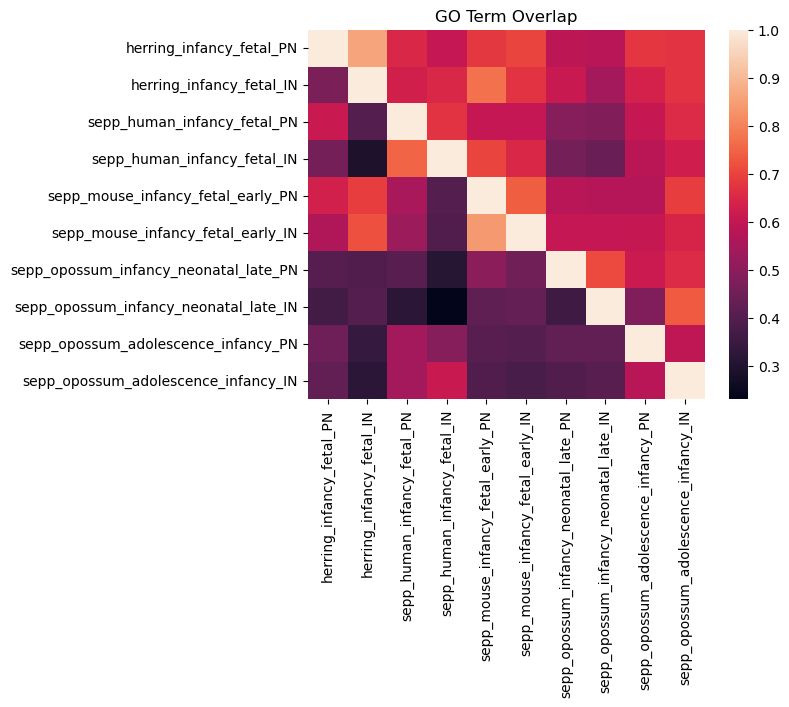

In [13]:
g = sns.heatmap(overlaps)
g.set_title('GO Term Overlap')

Checking for overlaps in this way doesn't really tell us a whole lot - probably because it's difficult to evaluate similarity when there are so many terms which are similar but aren't the same, may be best to use the actual differential gene data for this kind of thing instead

In [14]:
g.get_figure().savefig(str(FIG_PATH+'stagewise_go_term_overlaps_dotplot.svg'), dpi=300, bbox_inches='tight') 

Look specifically for enriched transcription factor binding sites 

In [89]:
tf_upreg = {}
tf_downreg = {}
for comp_up, comp_down in zip(upreg, downreg):
    up = upreg[comp_up]
    down = downreg[comp_down]
    tf_up = {}
    tf_down = {}
    for cell_type in cell_types:
        if cell_type in up.keys():
            tf_up[cell_type] = up[cell_type][up[cell_type]['source'] == 'TF']
        if cell_type in down.keys():
            tf_down[cell_type] = down[cell_type][down[cell_type]['source'] == 'TF']
    tf_upreg[comp_up] = tf_up
    tf_downreg[comp_down] = tf_down

In [90]:
tf_upreg

{'herring_infancy_fetal_': {'PN':     source       native                                               name  \
  70      TF  TF:M07040_1  Factor: GKLF; motif: NNRRGRRNGNSNNN; match cla...   
  89      TF    TF:M07436                   Factor: WT1; motif: NNGGGNGGGSGN   
  98      TF  TF:M13127_1  Factor: HA95; motif: CCSNSSCCNSCNCCWSCCNS; mat...   
  107     TF  TF:M09984_1  Factor: MAZ; motif: GGGGGAGGGGGNGRGRRRGNRG; ma...   
  109     TF    TF:M02023                 Factor: MAZ; motif: NKGGGAGGGGRGGR   
  ..     ...          ...                                                ...   
  705     TF    TF:M01072               Factor: HIC1; motif: NSNNNNTGCCCSSNN   
  708     TF    TF:M12255                     Factor: SNA; motif: NRCAGGTGCN   
  717     TF  TF:M09890_1  Factor: ctcf; motif: YGGCCACCAGRKGGCRSYN; matc...   
  718     TF    TF:M08867                     Factor: AP2; motif: GCCYGSGGSN   
  724     TF  TF:M07407_1    Factor: THAP1; motif: YTGCCCNNA; match class: 1   
  
     

In [91]:
# Collate results into a single CSV
summary = None
path = '/group/ll005/cmcphan/notebooks/analysis/results/transcription_factors/'
for comp in tf_upreg:
    for cell_type in tf_upreg[comp]:
        data = tf_upreg[comp][cell_type]
        data.insert(0, 'dataset', comp[:-1])
        data.insert(1, 'cell_type', cell_type)
        data.insert(2, 'direction_of_change', 'up')
        summary = pd.concat([summary, data])
for comp in tf_downreg:
    for cell_type in tf_downreg[comp]:
        data = tf_downreg[comp][cell_type]
        data.insert(0, 'dataset', comp[:-1])
        data.insert(1, 'cell_type', cell_type)
        data.insert(2, 'direction_of_change', 'down')
        summary = pd.concat([summary, data])
summary.reset_index(inplace=True, drop=True)
summary.to_csv(str(path+'tf_results_summary.csv'))
summary

dataset cell_type direction_of_change source  \
0              herring_infancy_fetal        PN                  up     TF   
1              herring_infancy_fetal        PN                  up     TF   
2              herring_infancy_fetal        PN                  up     TF   
3              herring_infancy_fetal        PN                  up     TF   
4              herring_infancy_fetal        PN                  up     TF   
...                              ...       ...                 ...    ...   
4355  sepp_mouse_infancy_fetal_early        IN                down     TF   
4356  sepp_mouse_infancy_fetal_early        IN                down     TF   
4357  sepp_mouse_infancy_fetal_early        IN                down     TF   
4358  sepp_mouse_infancy_fetal_early        IN                down     TF   
4359  sepp_mouse_infancy_fetal_early        IN                down     TF   

           native                                               name  \
0     TF:M07040_1  Factor: GKLF; motif: NNRRGRRNGNSNNN; match cla...   
1       TF:M07436                   Factor: WT1; motif: NNGGGNGGGSGN   
2     TF:M13127_1  Factor: HA95; motif: CCSNSSCCNSCNCCWSCCNS; mat...   
3     TF:M09984_1  Factor: MAZ; motif: GGGGGAGGGGGNGRGRRRGNRG; ma...   
4       TF:M02023                 Factor: MAZ; motif: NKGGGAGGGGRGGR   
...           ...                                                ...   
4355    TF:M01231                  Factor: ZNF515; motif: GTGGGGGGTM   
4356  TF:M07042_1  Factor: HES-1; motif: NNCKYGTGNNN; match class: 1   
4357  TF:M00243_1  Factor: Egr-1; motif: WTGCGTGGGCGK; match clas...   
4358    TF:M10175             Factor: AP-2alpha; motif: NNNSCCTGRGGC   
4359    TF:M00143  Factor: Pax-5; motif: BCNNNRNGCANBGNTGNRTAGCSG...   

           p_value  significant  \
0     2.607893e-16         True   
1     1.973879e-13         True   
2     6.974544e-12         True   
3     2.444481e-11         True   
4     4.635585e-11         True   
...            ...          ...   
4355  3.641726e-02         True   
4356  3.673434e-02         True   
4357  3.872846e-02         True   
4358  4.168101e-02         True   
4359  4.571051e-02         True   

                                            description  term_size  \
0     Factor: GKLF; motif: NNRRGRRNGNSNNN; match cla...       8420   
1                      Factor: WT1; motif: NNGGGNGGGSGN       6709   
2     Factor: HA95; motif: CCSNSSCCNSCNCCWSCCNS; mat...       8631   
3     Factor: MAZ; motif: GGGGGAGGGGGNGRGRRRGNRG; ma...       5755   
4                    Factor: MAZ; motif: NKGGGAGGGGRGGR       7353   
...                                                 ...        ...   
4355                  Factor: ZNF515; motif: GTGGGGGGTM       1704   
4356  Factor: HES-1; motif: NNCKYGTGNNN; match class: 1        599   
4357  Factor: Egr-1; motif: WTGCGTGGGCGK; match clas...        859   
4358             Factor: AP-2alpha; motif: NNNSCCTGRGGC       4924   
4359  Factor: Pax-5; motif: BCNNNRNGCANBGNTGNRTAGCSG...      10809   

      query_size  intersection_size  effective_domain_size  precision  \
0           1217                664                  20044   0.545604   
1           1217                543                  20044   0.446179   
2           1217                657                  20044   0.539852   
3           1217                471                  20044   0.387017   
4           1217                573                  20044   0.470830   
...          ...                ...                    ...        ...   
4355         519                 68                  21628   0.131021   
4356         519                 32                  21628   0.061657   
4357         519                 41                  21628   0.078998   
4358         519                158                  21628   0.304432   
4359         519                305                  21628   0.587669   

        recall    query        parents  \
0     0.078860  query_1  ['TF:M07040']   
1     0.080936  

In [92]:
comps = ['herring_infancy_fetal_', 'sepp_human_infancy_fetal_', 'sepp_mouse_infancy_fetal_early_', 
         'sepp_opossum_infancy_neonatal_late_', 'sepp_opossum_adolescence_infancy_']
index = []
df_matrix = []
for y in range(0, len(comps)):
    comp_y = comps[y]
    for cell_type_y in ['PN', 'IN']:
        props = []
        index.append(str(comps[y]+cell_type_y))
        for x in range(0, len(comps)):
            comp_x = comps[x]
            for cell_type_x in ['PN', 'IN']:
                if x == y:
                    if cell_type_x == cell_type_y:
                        props.append(1) # Perfect overlap with self
                    elif cell_type_x == 'PN' and cell_type_y == 'IN':
                        terms_x = tf_downreg[comp_x][cell_type_x]['native'].values
                        terms_y = tf_downreg[comp_y][cell_type_y]['native'].values
                        overlap = [g for g in terms_x if g in terms_y]
                        try:
                            props.append(len(overlap)/len(terms_x))
                        except ZeroDivisionError:
                            props.append(0)
                    elif cell_type_x == 'IN' and cell_type_y == 'PN':
                        terms_x = tf_upreg[comp_x][cell_type_x]['native'].values
                        terms_y = tf_upreg[comp_y][cell_type_y]['native'].values
                        overlap = [g for g in terms_x if g in terms_y]
                        try:
                            props.append(len(overlap)/len(terms_x))
                        except ZeroDivisionError:
                            props.append(0)
                elif x > y: # Top half is upregulated results
                    terms_x = tf_upreg[comp_x][cell_type_x]['native'].values
                    terms_y = tf_upreg[comp_y][cell_type_y]['native'].values
                    overlap = [g for g in terms_x if g in terms_y]
                    try:
                        props.append(len(overlap)/len(terms_x))
                    except ZeroDivisionError:
                            props.append(0)
                elif x < y: # Bottom half is downregulated results
                    terms_x = tf_downreg[comp_x][cell_type_x]['native'].values
                    terms_y = tf_downreg[comp_y][cell_type_y]['native'].values
                    overlap = [g for g in terms_x if g in terms_y]
                    try:
                        props.append(len(overlap)/len(terms_x)) # Calculate overlap as proportion of DEGs in index list
                    except ZeroDivisionError:
                        props.append(0)
        df_matrix.append(props)
overlaps = pd.DataFrame(df_matrix, index=index, columns=index)
overlaps

herring_infancy_fetal_PN  \
herring_infancy_fetal_PN                               1.000000   
herring_infancy_fetal_IN                               0.737313   
sepp_human_infancy_fetal_PN                            0.928358   
sepp_human_infancy_fetal_IN                            0.641791   
sepp_mouse_infancy_fetal_early_PN                      0.265672   
sepp_mouse_infancy_fetal_early_IN                      0.265672   
sepp_opossum_infancy_neonatal_late_PN                  0.000000   
sepp_opossum_infancy_neonatal_late_IN                  0.000000   
sepp_opossum_adolescence_infancy_PN                    0.000000   
sepp_opossum_adolescence_infancy_IN                    0.000000   

                                       herring_infancy_fetal_IN  \
herring_infancy_fetal_PN                               0.403846   
herring_infancy_fetal_IN                               1.000000   
sepp_human_infancy_fetal_PN                            0.909091   
sepp_human_infancy_fetal_IN                            0.657576   
sepp_mouse_infancy_fetal_early_PN                      0.275758   
sepp_mouse_infancy_fetal_early_IN                      0.278788   
sepp_opossum_infancy_neonatal_late_PN                  0.000000   
sepp_opossum_infancy_neonatal_late_IN                  0.000000   
sepp_opossum_adolescence_infancy_PN                    0.000000   
sepp_opossum_adolescence_infancy_IN                    0.000000   

                                       sepp_human_infancy_fetal_PN  \
herring_infancy_fetal_PN                                  0.462604   
herring_infancy_fetal_IN                                  0.927978   
sepp_human_infancy_fetal_PN                               1.000000   
sepp_human_infancy_fetal_IN                               0.542461   
sepp_mouse_infancy_fetal_early_PN                         0.298094   
sepp_mouse_infancy_fetal_early_IN                         0.299827   
sepp_opossum_infancy_neonatal_late_PN                     0.000000   
sepp_opossum_infancy_neonatal_late_IN                     0.000000   
sepp_opossum_adolescence_infancy_PN                       0.000000   
sepp_opossum_adolescence_infancy_IN                       0.000000   

                                       sepp_human_infancy_fetal_IN  \
herring_infancy_fetal_PN                                  0.436137   
herring_infancy_fetal_IN                                  0.922118   
sepp_human_infancy_fetal_PN                               0.872274   
sepp_human_infancy_fetal_IN                               1.000000   
sepp_mouse_infancy_fetal_early_PN                         0.313291   
sepp_mouse_infancy_fetal_early_IN                         0.316456   
sepp_opossum_infancy_neonatal_late_PN                     0.000000   
sepp_opossum_infancy_neonatal_late_IN                     0.000000   
sepp_opossum_adolescence_infancy_PN                       0.000000   
sepp_opossum_adolescence_infancy_IN                       0.000000   

                                       sepp_mouse_infancy_fetal_early_PN  \
herring_infancy_fetal_PN                                        0.403101   
herring_infancy_fetal_IN                                        0.620155   
sepp_human_infancy_fetal_PN                                     0.558140   
sepp_human_infancy_fetal_IN                                     0.534884   
sepp_mouse_infancy_fetal_early_PN                               1.000000   
sepp_mouse_infancy_fetal_early_IN                               0.919355   
sepp_opossum_infancy_neonatal_late_PN                           0.000000   
sepp_opossum_infancy_neonatal_late_IN                           0.000000   
sepp_opossum_adolescence_infancy_PN                             0.000000   
sepp_opossum_adolescence_infancy_IN                             0.000000   

                                       sepp_mouse_infancy_fetal_early_IN  \
herring_infancy_fetal_PN                                        0.314516   
herring_infancy_fetal_IN        

Text(0.5, 1.0, 'Transcription Factor Binding Sites Overlap')

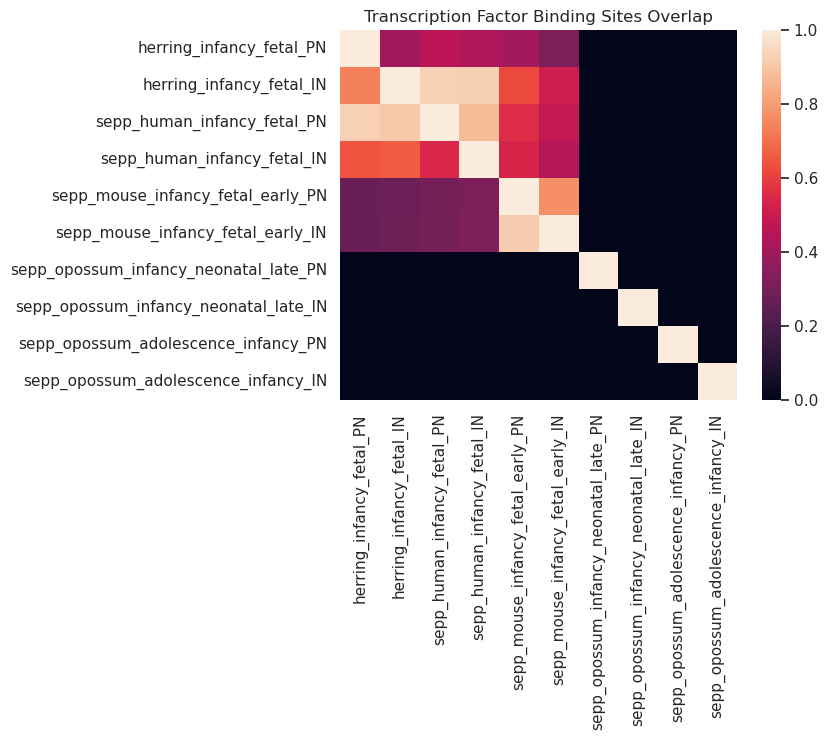

In [93]:
g = sns.heatmap(overlaps)
g.set_title('Transcription Factor Binding Sites Overlap')

In [115]:
g.get_figure().savefig(str(FIG_PATH+'stagewise_TF_overlaps_dotplot.svg'), dpi=300, bbox_inches='tight') 

In [103]:
tf_upreg.keys()

dict_keys(['herring_infancy_fetal_', 'sepp_human_infancy_fetal_', 'sepp_mouse_infancy_fetal_early_', 'sepp_opossum_infancy_neonatal_late_', 'sepp_opossum_adolescence_infancy_'])

In [102]:
print(len(tf_upreg['sepp_opossum_adolescence_infancy_']['PN']['native'].values.tolist()))
print(len(tf_downreg['sepp_opossum_adolescence_infancy_']['PN']['native'].values.tolist()))
print(len(tf_upreg['sepp_opossum_adolescence_infancy_']['IN']['native'].values.tolist()))
print(len(tf_downreg['sepp_opossum_adolescence_infancy_']['IN']['native'].values.tolist()))

0
0
0
0


In [104]:
print(len(tf_upreg['sepp_opossum_infancy_neonatal_late_']['PN']['native'].values.tolist()))
print(len(tf_downreg['sepp_opossum_infancy_neonatal_late_']['PN']['native'].values.tolist()))
print(len(tf_upreg['sepp_opossum_infancy_neonatal_late_']['IN']['native'].values.tolist()))
print(len(tf_downreg['sepp_opossum_infancy_neonatal_late_']['IN']['native'].values.tolist()))

0
0
0
0


Seems like G:profiler is unable to get results for the opossum from TRANSFAC so opossum will need to be excluded from this section

In [117]:
# Look for commonalities in TFs across stages/species
common_up = {}
common_down = {}
# Those that were only present in either the up or down regulated genes, but not both
unique_up = {}
unique_down = {}
for cell_type in ['PN', 'IN']:
    up = tf_upreg['herring_infancy_fetal_'][cell_type]
    down = tf_downreg['herring_infancy_fetal_'][cell_type]
    for comp in ['sepp_human_infancy_fetal_', 'sepp_mouse_infancy_fetal_early_']:
        up = pd.concat([up, tf_upreg[comp][cell_type]])
        up = up.loc[up.duplicated(subset='native')].drop_duplicates()[['source', 'native', 'name']]
        down = pd.concat([down, tf_downreg[comp][cell_type]])
        down = down.loc[down.duplicated(subset='native')].drop_duplicates()[['source', 'native', 'name']]
    up.reset_index(inplace=True, drop=True)
    down.reset_index(inplace=True, drop=True)
    common_up[cell_type] = up
    common_down[cell_type] = down
    up = up.loc[up['native'].isin([g for g in up['native'].values.tolist() if g not in down['native'].values.tolist()])]
    down = down.loc[down['native'].isin([g for g in down['native'].values.tolist() if g not in up['native'].values.tolist()])]
    up.reset_index(inplace=True, drop=True)
    down.reset_index(inplace=True, drop=True)
    unique_up[cell_type] = up
    unique_down[cell_type] = down

In [118]:
common_up

{'PN':    source       native                                               name
 0      TF    TF:M01104                     Factor: MOVO-B; motif: GNGGGGG
 1      TF    TF:M07040                Factor: GKLF; motif: NNRRGRRNGNSNNN
 2      TF  TF:M07040_1  Factor: GKLF; motif: NNRRGRRNGNSNNN; match cla...
 3      TF  TF:M01865_1  Factor: BTEB3; motif: BNRNGGGAGGNGT; match cla...
 4      TF  TF:M07289_1  Factor: GKLF; motif: NNNRGGNGNGGSN; match clas...
 5      TF    TF:M01118                      Factor: WT1; motif: SMCNCCNSC
 6      TF    TF:M01219                Factor: SP1:SP3; motif: CCSCCCCCYCC
 7      TF    TF:M01587                Factor: FPM315; motif: SRGGGAGGAGGN
 8      TF    TF:M07289                 Factor: GKLF; motif: NNNRGGNGNGGSN
 9      TF  TF:M03876_1  Factor: Kaiso; motif: GCMGGGRGCRGS; match clas...
 10     TF    TF:M00649                       Factor: MAZ; motif: GGGGAGGG
 11     TF    TF:M00982                Factor: KROX; motif: CCCGCCCCCRCCCC
 12     TF    TF:M0

In [119]:
common_down

{'PN':    source       native                                               name
 0      TF  TF:M00716_1       Factor: ZF5; motif: GSGCGCGR; match class: 1
 1      TF    TF:M00803                         Factor: E2F; motif: GGCGSG
 2      TF  TF:M00803_1         Factor: E2F; motif: GGCGSG; match class: 1
 3      TF    TF:M00716                       Factor: ZF5; motif: GSGCGCGR
 4      TF    TF:M02089                      Factor: E2F-3; motif: GGCGGGN
 ..    ...          ...                                                ...
 83     TF    TF:M01273                    Factor: SP4; motif: SCCCCGCCCCS
 84     TF  TF:M01588_1  Factor: GKLF; motif: GCCMCRCCCNNN; match class: 1
 85     TF  TF:M01100_1      Factor: LRF; motif: GGGGKYNNB; match class: 1
 86     TF  TF:M03811_1  Factor: AP-2gamma; motif: GCCYNCRGSN; match cl...
 87     TF    TF:M01284                  Factor: Sox-9; motif: RNACAAAGGVN
 
 [88 rows x 3 columns],
 'IN':    source       native                                       

Look for those that were uniquely enriched in the up or down sets

In [120]:
unique_up

{'PN':    source       native                                               name
 0      TF    TF:M07040                Factor: GKLF; motif: NNRRGRRNGNSNNN
 1      TF  TF:M07040_1  Factor: GKLF; motif: NNRRGRRNGNSNNN; match cla...
 2      TF  TF:M01865_1  Factor: BTEB3; motif: BNRNGGGAGGNGT; match cla...
 3      TF    TF:M01587                Factor: FPM315; motif: SRGGGAGGAGGN
 4      TF    TF:M00649                       Factor: MAZ; motif: GGGGAGGG
 5      TF  TF:M01219_1  Factor: SP1:SP3; motif: CCSCCCCCYCC; match cla...
 6      TF    TF:M07329                    Factor: Osx; motif: CCNCCCCCNNN
 7      TF    TF:M07436                   Factor: WT1; motif: NNGGGNGGGSGN
 8      TF    TF:M01073            Factor: HIC1; motif: NNNGGKTGCCCSNNNNNN
 9      TF    TF:M01837                    Factor: FKLF; motif: BGGGNGGVMD
 10     TF    TF:M01865                Factor: BTEB3; motif: BNRNGGGAGGNGT
 11     TF  TF:M07436_1   Factor: WT1; motif: NNGGGNGGGSGN; match class: 1
 12     TF    TF:M0

In [121]:
unique_down

{'PN':    source       native                                               name
 0      TF  TF:M00716_1       Factor: ZF5; motif: GSGCGCGR; match class: 1
 1      TF    TF:M00803                         Factor: E2F; motif: GGCGSG
 2      TF  TF:M00803_1         Factor: E2F; motif: GGCGSG; match class: 1
 3      TF    TF:M00716                       Factor: ZF5; motif: GSGCGCGR
 4      TF    TF:M02089                      Factor: E2F-3; motif: GGCGGGN
 ..    ...          ...                                                ...
 83     TF    TF:M01273                    Factor: SP4; motif: SCCCCGCCCCS
 84     TF  TF:M01588_1  Factor: GKLF; motif: GCCMCRCCCNNN; match class: 1
 85     TF  TF:M01100_1      Factor: LRF; motif: GGGGKYNNB; match class: 1
 86     TF  TF:M03811_1  Factor: AP-2gamma; motif: GCCYNCRGSN; match cl...
 87     TF    TF:M01284                  Factor: Sox-9; motif: RNACAAAGGVN
 
 [88 rows x 3 columns],
 'IN':    source       native                                       

Look for any that are uniquely up or down regulated across both neuronal cell types across all 3 datasets

In [129]:
up = pd.concat([unique_up['PN'], unique_up['IN']])
up = up.loc[up.duplicated(subset='native')].drop_duplicates()[['source', 'native', 'name']]
up.reset_index(inplace=True, drop=True)
up

source       native                                               name
0     TF    TF:M07040                Factor: GKLF; motif: NNRRGRRNGNSNNN
1     TF    TF:M07436                   Factor: WT1; motif: NNGGGNGGGSGN
2     TF  TF:M07040_1  Factor: GKLF; motif: NNRRGRRNGNSNNN; match cla...
3     TF    TF:M01587                Factor: FPM315; motif: SRGGGAGGAGGN
4     TF    TF:M01837                    Factor: FKLF; motif: BGGGNGGVMD
5     TF    TF:M08819                     Factor: LKLF; motif: CNCCACCCS
6     TF    TF:M00649                       Factor: MAZ; motif: GGGGAGGG
7     TF    TF:M01073            Factor: HIC1; motif: NNNGGKTGCCCSNNNNNN
8     TF  TF:M00470_1  Factor: AP-2gamma; motif: GCCYNNGGS; match cla...

In [130]:
down = pd.concat([unique_down['PN'], unique_down['IN']])
down = down.loc[down.duplicated(subset='native')].drop_duplicates()[['source', 'native', 'name']]
down.reset_index(inplace=True, drop=True)
down

source       native                                               name
0      TF  TF:M00716_1       Factor: ZF5; motif: GSGCGCGR; match class: 1
1      TF    TF:M00716                       Factor: ZF5; motif: GSGCGCGR
2      TF    TF:M00803                         Factor: E2F; motif: GGCGSG
3      TF  TF:M00333_1  Factor: ZF5; motif: NRNGNGCGCGCWN; match class: 1
4      TF  TF:M00803_1         Factor: E2F; motif: GGCGSG; match class: 1
5      TF    TF:M01199                   Factor: RNF96; motif: BCCCGCRGCC
6      TF  TF:M02089_1      Factor: E2F-3; motif: GGCGGGN; match class: 1
7      TF  TF:M01199_1   Factor: RNF96; motif: BCCCGCRGCC; match class: 1
8      TF  TF:M07289_1  Factor: GKLF; motif: NNNRGGNGNGGSN; match clas...
9      TF    TF:M00333                  Factor: ZF5; motif: NRNGNGCGCGCWN
10     TF    TF:M01104                     Factor: MOVO-B; motif: GNGGGGG
11     TF    TF:M02089                      Factor: E2F-3; motif: GGCGGGN
12     TF    TF:M02036                     Factor: WT1; motif: CGCCCCCNCN
13     TF  TF:M01240_1       Factor: BEN; motif: CAGCGRNV; match class: 1
14     TF    TF:M07354                   Factor: Egr-1; motif: GCGGGGGCGG
15     TF    TF:M00933                     Factor: Sp1; motif: CCCCGCCCCN
16     TF    TF:M01240                       Factor: BEN; motif: CAGCGRNV
17     TF    TF:M00982                Factor: KROX; motif: CCCGCCCCCRCCCC
18     TF  TF:M00933_1     Factor: Sp1; motif: CCCCGCCCCN; match class: 1
19     TF    TF:M08878                    Factor: EGR; motif: CGCCCCCGCNN
20     TF  TF:M07354_1   Factor: Egr-1; motif: GCGGGGGCGG; match class: 1
21     TF    TF:M01219                Factor: SP1:SP3; motif: CCSCCCCCYCC
22     TF    TF:M01118                      Factor: WT1; motif: SMCNCCNSC
23     TF    TF:M00932                  Factor: Sp1; motif: NNGGGGCGGGGNN
24     TF    TF:M00931                     Factor: Sp1; motif: GGGGCGGGGC
25     TF  TF:M00931_1     Factor: Sp1; motif: GGGGCGGGGC; match class: 1
26     TF  TF:M01104_1     Factor: MOVO-B; motif: GNGGGGG; match class: 1
27     TF    TF:M07250                Factor: E2F-1; motif: NNNSSCGCSAANN
28     TF  TF:M00932_1  Factor: Sp1; motif: NNGGGGCGGGGNN; match class: 1
29     TF    TF:M07395                    Factor: Sp1; motif: NGGGGCGGGGN
30     TF  TF:M07395_1    Factor: Sp1; motif: NGGGGCGGGGN; match class: 1
31     TF    TF:M01873                   Factor: Egr-1; motif: GCGGGGGCGG
32     TF    TF:M03893                   Factor: WT1; motif: GNGGGGGCGGGG
33     TF    TF:M01857              Factor: AP-2alpha; motif: NGCCYSNNGSN
34     TF    TF:M00800              Factor: AP-2; motif: GSCCSCRGGCNRNRNN
35     TF  TF:M07380_1   Factor: E2F-4; motif: NTTTCSCGCC; match class: 1
36     TF    TF:M03807                Factor: SP2; motif: GNNGGGGGCGGGGSN
37     TF    TF:M01175                    Factor: CKROX; motif: SCCCTCCCC
38     TF    TF:M00196                  Factor: Sp1; motif: NGGGGGCGGGGYN
39     TF  TF:M02036_1     Factor: WT1; motif: CGCCCCCNCN; match class: 1
40     TF  TF:M00196_1  Factor: Sp1; motif: NGGGGGCGGGGYN; match class: 1
41     TF  TF:M07250_1  Factor: E2F-1; motif: NNNSSCGCSAANN; match cla...
42     TF  TF:M07397_1  Factor: ZBP89; motif: CCCCKCCCCCNN; match clas...
43     TF    TF:M07397                 Factor: ZBP89; motif: CCCCKCCCCCNN
44     TF    TF:M03567                Factor: Sp2; motif: NYSGCCCCGCCCCCY
45     TF  TF:M03893_1   Factor: WT1; motif: GNGGGGGCGGGG; match class: 1
46     TF    TF:M01303                    Factor: SP1; motif: GGGGYGGGGNS
47     TF  TF:M08878_1    Factor: EGR; motif: CGCCCCCGCNN; match class: 1
48     TF    TF:M00008                     Factor: Sp1; motif: GGGGCGGGGT
49     TF    TF:M07277                   Factor: BTEB2; motif: RGGGNGKGGN
50     TF  TF:M01857_1  Factor: AP-2alpha; motif: NGCCYSNNGSN; match c...
51     TF  TF:M03807_1  Factor: SP2; motif: GNNGGGGGCGGGGSN; match cla...
52     TF  TF:M07277_1   Factor: BTEB2; motif: RGGGNGKGGN; match class: 1
53     

In [131]:
# Collate results into a single CSV
summary = None
path = '/group/ll005/cmcphan/notebooks/analysis/results/transcription_factors/'
data = up
data.insert(1, 'direction_of_change', 'up')
summary = pd.concat([summary, data])
data = down
data.insert(1, 'direction_of_change', 'down')
summary = pd.concat([summary, data])
summary.reset_index(inplace=True, drop=True)
summary.to_csv(str(path+'common_tf_results_summary.csv'))
summary

source direction_of_change       native  \
0      TF                  up    TF:M07040   
1      TF                  up    TF:M07436   
2      TF                  up  TF:M07040_1   
3      TF                  up    TF:M01587   
4      TF                  up    TF:M01837   
..    ...                 ...          ...   
61     TF                down  TF:M07277_1   
62     TF                down    TF:M07617   
63     TF                down  TF:M03567_1   
64     TF                down  TF:M00008_1   
65     TF                down    TF:M01284   

                                                 name  
0                 Factor: GKLF; motif: NNRRGRRNGNSNNN  
1                    Factor: WT1; motif: NNGGGNGGGSGN  
2   Factor: GKLF; motif: NNRRGRRNGNSNNN; match cla...  
3                 Factor: FPM315; motif: SRGGGAGGAGGN  
4                     Factor: FKLF; motif: BGGGNGGVMD  
..                                                ...  
61   Factor: BTEB2; motif: RGGGNGKGGN; match class: 1  
62                  Factor: Sp4; motif: SCCCCKCCCCCSN  
63  Factor: Sp2; motif: NYSGCCCCGCCCCCY; match cla...  
64     Factor: Sp1; motif: GGGGCGGGGT; match class: 1  
65                  Factor: Sox-9; motif: RNACAAAGGVN  

[66 rows x 4 columns]

---

### Agewise Comparisons
Note that comparisons in this section have the added caveat that cell types have not been separated, and therefore any changes that appear may be due to changes in cell type proportions rather than due to age progression

In [132]:
# Read in all cell type split GO results for a given comparison
upreg = {}
downreg = {}
paths = ['/group/ll005/cmcphan/notebooks/analysis/results/herring/agewise/go_results/all_genes/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/human/agewise/go_results/all_genes/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/agewise/go_results/all_genes/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/agewise/go_results/all_genes/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/agewise/go_results/all_genes/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/agewise/go_results/all_genes/']
comps = ['herring_86d_ga24', 'sepp_human_5d_20wpc', 'sepp_mouse_P4_EM13.5', 'sepp_mouse_9w_P7',
         'sepp_opossum_P5_EO14', 'sepp_opossum_P60_P21']
prefixes = ['go_up_', 'go_down_']
for path, comp in zip(paths, comps):
    up = {}
    down = {}
    for prefix in prefixes:
            res = pd.read_csv(str(path+prefix+comp), index_col=0)
            if prefix == 'go_up_':
                upreg[comp] = res
            elif prefix == 'go_down_':
                downreg[comp] = res
upreg

{'herring_86d_ga24':     source       native                                               name  \
 0    GO:CC   GO:0045202                                            synapse   
 1    GO:CC   GO:0030054                                      cell junction   
 2       TF  TF:M00716_1       Factor: ZF5; motif: GSGCGCGR; match class: 1   
 3    GO:CC   GO:0043005                                  neuron projection   
 4    GO:CC   GO:0036477                        somatodendritic compartment   
 ..     ...          ...                                                ...   
 990  GO:MF   GO:0042626  ATPase-coupled transmembrane transporter activity   
 991  GO:CC   GO:0031966                             mitochondrial membrane   
 992     TF    TF:M00665                 Factor: Sp3; motif: ASMCTTGGGSRGGG   
 993     TF    TF:M12183                Factor: KLF14; motif: NRCCACRCCCMCN   
 994     TF    TF:M08283      Factor: Fli-1:ETV7; motif: NSMGGAMGGATNTCCGNN   
 
           p_value  significan

In [133]:
# Generate list of 10 most enriched terms for each result, remove any terms that appear in both the up and down regulated lists
most_enriched_up = pd.DataFrame(columns=['source', 'native', 'name'])
most_enriched_down = pd.DataFrame(columns=['source', 'native', 'name'])
up = upreg['herring_86d_ga24']
down = downreg['herring_86d_ga24']
# Get only the GO terms which are not also in the opposite results for the same cell type - i.e. those that are 
#    uniquely up- or down-regulated
unique_up = up[up['source'].isin(['GO:BP', 'GO:MF', 'KEGG', 'REAC', 'WP'])].sort_values(by='p_value')[['source', 'native', 'name']]
unique_up_ids = [g for g in unique_up['native'].values if g not in down['native'].values]
unique_up = up[up['native'].isin(unique_up_ids)]
unique_up = unique_up.loc[[True if len(ast.literal_eval(p)) >= 2 else False for p in unique_up['parents'].values]]
most_enriched_up = pd.concat([most_enriched_up, unique_up]).drop_duplicates()

unique_down = down[down['source'].isin(['GO:BP', 'GO:MF', 'KEGG', 'REAC', 'WP'])].sort_values(by='p_value')[['source', 'native', 'name']]
unique_down_ids = [g for g in unique_down['native'].values if g not in up['native'].values]
unique_down = down[down['native'].isin(unique_down_ids)]
unique_down = unique_down.loc[[True if len(ast.literal_eval(p)) >= 2 else False for p in unique_down['parents'].values]]
most_enriched_down = pd.concat([most_enriched_down, unique_down]).drop_duplicates()

In [134]:
most_enriched_up.reset_index(inplace=True, drop=True)
most_enriched_up = most_enriched_up.sort_values(by='p_value')
up = pd.DataFrame(columns=['source', 'native', 'name'])
for i in range(0, len(most_enriched_up)):
    if len(up) >= 25:
        break
    term = most_enriched_up.iloc[i]
    if term['native'] in up['native'].values:
        continue
    else:
        up.loc[len(up)] = term[['source', 'native', 'name']]
up

source      native                                              name
0   GO:BP  GO:0050804      modulation of chemical synaptic transmission
1   GO:BP  GO:0099177            regulation of trans-synaptic signaling
2   GO:BP  GO:0007267                               cell-cell signaling
3   GO:BP  GO:0055085                           transmembrane transport
4   GO:BP  GO:0071805             potassium ion transmembrane transport
5   GO:BP  GO:0034220            monoatomic ion transmembrane transport
6   GO:MF  GO:0046873      metal ion transmembrane transporter activity
7   GO:BP  GO:0099504                            synaptic vesicle cycle
8   GO:BP  GO:0032879                        regulation of localization
9   GO:BP  GO:0098655         monoatomic cation transmembrane transport
10  GO:BP  GO:0007269                        neurotransmitter secretion
11  GO:BP  GO:0099643                       signal release from synapse
12  GO:BP  GO:0048167                 regulation of synaptic plasticity
13  GO:BP  GO:0007611                                learning or memory
14  GO:BP  GO:0140352                                  export from cell
15  GO:BP  GO:0016079                       synaptic vesicle exocytosis
16  GO:BP  GO:0051049                           regulation of transport
17  GO:MF  GO:0005249          voltage-gated potassium channel activity
18  GO:MF  GO:0005267                        potassium channel activity
19  GO:MF  GO:0005216                   monoatomic ion channel activity
20  GO:BP  GO:0035725                sodium ion transmembrane transport
21  GO:MF  GO:0005261                monoatomic cation channel activity
22  GO:MF  GO:0022843  voltage-gated monoatomic cation channel activity
23  GO:MF  GO:0005244     voltage-gated monoatomic ion channel activity
24  GO:BP  GO:0051641                             cellular localization

In [135]:
most_enriched_down.reset_index(inplace=True, drop=True)
most_enriched_down = most_enriched_down.sort_values(by='p_value')
down = pd.DataFrame(columns=['source', 'native', 'name'])
for i in range(0, len(most_enriched_down)):
    if len(down) >= 25:
        break
    term = most_enriched_down.iloc[i]
    if term['native'] in down['native'].values:
        continue
    else:
        down.loc[len(down)] = term[['source', 'native', 'name']]
down

source      native                                               name
0   GO:BP  GO:0048518          positive regulation of biological process
1   GO:BP  GO:0048522            positive regulation of cellular process
2   GO:BP  GO:0080090            regulation of primary metabolic process
3   GO:BP  GO:0048523            negative regulation of cellular process
4   GO:BP  GO:0048519          negative regulation of biological process
5   GO:BP  GO:0022402                                 cell cycle process
6   GO:BP  GO:1903047                         mitotic cell cycle process
7   GO:BP  GO:0019222                    regulation of metabolic process
8   GO:BP  GO:0042127        regulation of cell population proliferation
9   GO:BP  GO:0048869                     cellular developmental process
10  GO:BP  GO:0051726                           regulation of cell cycle
11  GO:BP  GO:0009893           positive regulation of metabolic process
12  GO:BP  GO:0045595                 regulation of cell differentiation
13  GO:BP  GO:0008284  positive regulation of cell population prolife...
14  GO:BP  GO:0044772                mitotic cell cycle phase transition
15  GO:BP  GO:0051239     regulation of multicellular organismal process
16  GO:BP  GO:0060255      regulation of macromolecule metabolic process
17  GO:BP  GO:0019219  regulation of nucleobase-containing compound m...
18  GO:BP  GO:0000070               mitotic sister chromatid segregation
19  GO:BP  GO:0010564                   regulation of cell cycle process
20  GO:BP  GO:2000026  regulation of multicellular organismal develop...
21  GO:BP  GO:0009891        positive regulation of biosynthetic process
22  GO:BP  GO:0007346                   regulation of mitotic cell cycle
23  GO:BP  GO:0048585        negative regulation of response to stimulus
24  GO:BP  GO:0009889                 regulation of biosynthetic process

In [136]:
most_enriched = pd.concat([up, down])
most_enriched.reset_index(inplace=True, drop=True)
most_enriched

source      native                                               name
0   GO:BP  GO:0050804       modulation of chemical synaptic transmission
1   GO:BP  GO:0099177             regulation of trans-synaptic signaling
2   GO:BP  GO:0007267                                cell-cell signaling
3   GO:BP  GO:0055085                            transmembrane transport
4   GO:BP  GO:0071805              potassium ion transmembrane transport
5   GO:BP  GO:0034220             monoatomic ion transmembrane transport
6   GO:MF  GO:0046873       metal ion transmembrane transporter activity
7   GO:BP  GO:0099504                             synaptic vesicle cycle
8   GO:BP  GO:0032879                         regulation of localization
9   GO:BP  GO:0098655          monoatomic cation transmembrane transport
10  GO:BP  GO:0007269                         neurotransmitter secretion
11  GO:BP  GO:0099643                        signal release from synapse
12  GO:BP  GO:0048167                  regulation of synaptic plasticity
13  GO:BP  GO:0007611                                 learning or memory
14  GO:BP  GO:0140352                                   export from cell
15  GO:BP  GO:0016079                        synaptic vesicle exocytosis
16  GO:BP  GO:0051049                            regulation of transport
17  GO:MF  GO:0005249           voltage-gated potassium channel activity
18  GO:MF  GO:0005267                         potassium channel activity
19  GO:MF  GO:0005216                    monoatomic ion channel activity
20  GO:BP  GO:0035725                 sodium ion transmembrane transport
21  GO:MF  GO:0005261                 monoatomic cation channel activity
22  GO:MF  GO:0022843   voltage-gated monoatomic cation channel activity
23  GO:MF  GO:0005244      voltage-gated monoatomic ion channel activity
24  GO:BP  GO:0051641                              cellular localization
25  GO:BP  GO:0048518          positive regulation of biological process
26  GO:BP  GO:0048522            positive regulation of cellular process
27  GO:BP  GO:0080090            regulation of primary metabolic process
28  GO:BP  GO:0048523            negative regulation of cellular process
29  GO:BP  GO:0048519          negative regulation of biological process
30  GO:BP  GO:0022402                                 cell cycle process
31  GO:BP  GO:1903047                         mitotic cell cycle process
32  GO:BP  GO:0019222                    regulation of metabolic process
33  GO:BP  GO:0042127        regulation of cell population proliferation
34  GO:BP  GO:0048869                     cellular developmental process
35  GO:BP  GO:0051726                           regulation of cell cycle
36  GO:BP  GO:0009893           positive regulation of metabolic process
37  GO:BP  GO:0045595                 regulation of cell differentiation
38  GO:BP  GO:0008284  positive regulation of cell population prolife...
39  GO:BP  GO:0044772                mitotic cell cycle phase transition
40  GO:BP  GO:0051239     regulation of multicellular organismal process
41  GO:BP  GO:0060255      regulation of macromolecule metabolic process
42  GO:BP  GO:0019219  regulation of nucleobase-containing compound m...
43  GO:BP  GO:0000070               mitotic sister chromatid segregation
44  GO:BP  GO:0010564                   regulation of cell cycle process
45  GO:BP  GO:2000026  regulation of multicellular organismal develop...
46  GO:BP  GO:0009891        positive regulation of biosynthetic process
47  GO:BP  GO:0007346                   regulation of mitotic cell cycle
48  GO:BP  GO:0048585        negative regulation of response to stimulus
49  GO:BP  GO:0009889                 regulation of biosynthetic process

In [146]:
# Combine enriched terms into a single list and compile expression data for each term in each group
dotplot_df = pd.DataFrame(columns=['dataset', 'go_id', 'go_name', 'num_genes', 'mean_lfc'])
path = '/group/ll005/cmcphan/notebooks/analysis/results/herring/agewise/'
comp = 'herring_86d_ga24'
herring_dge = pd.read_csv(str(path+comp), index_col=0)
go_up = pd.read_csv(str(path+'go_results/all_genes/go_up_'+comp), index_col=0)
go_down = pd.read_csv(str(path+'go_results/all_genes/go_down_'+comp), index_col=0)
go_combined = pd.concat([go_up, go_down])
herring_go = go_combined
for i in most_enriched.index:
    term = most_enriched.loc[i]
    # Get list of intersecting genes for term
    intersections = herring_go[herring_go['native'] == term['native']]['intersections']
    gene_list = []
    for l in intersections:
        gene_list = gene_list + ast.literal_eval(l)
    # Gene list now contains all DEGs for this cell type associated with the current GO term
    # Get expression data for relevant genes from DEG result
    if len(gene_list) > 0:
        gene_data = herring_dge.loc[gene_list]
        mean_lfc = stats.mean(gene_data['log2FoldChange'])
    else:
        mean_lfc = np.nan
    dotplot_df.loc[len(dotplot_df)] = [comp, term['native'], term['name'], len(gene_list), mean_lfc]
dotplot_df

dataset       go_id  \
0   herring_86d_ga24  GO:0007267   
1   herring_86d_ga24  GO:0050804   
2   herring_86d_ga24  GO:0099177   
3   herring_86d_ga24  GO:0055085   
4   herring_86d_ga24  GO:0005216   
5   herring_86d_ga24  GO:0034220   
6   herring_86d_ga24  GO:0005261   
7   herring_86d_ga24  GO:0051049   
8   herring_86d_ga24  GO:0046873   
9   herring_86d_ga24  GO:0032879   
10  herring_86d_ga24  GO:0098655   
11  herring_86d_ga24  GO:0005244   
12  herring_86d_ga24  GO:0071805   
13  herring_86d_ga24  GO:0022843   
14  herring_86d_ga24  GO:0005267   
15  herring_86d_ga24  GO:0023051   
16  herring_86d_ga24  GO:0010646   
17  herring_86d_ga24  GO:0015276   
18  herring_86d_ga24  GO:0140352   
19  herring_86d_ga24  GO:0051716   
20  herring_86d_ga24  GO:0007165   
21  herring_86d_ga24  GO:0005249   
22  herring_86d_ga24  GO:0032940   
23  herring_86d_ga24  GO:0099094   
24  herring_86d_ga24  GO:0044057   
25  herring_86d_ga24  GO:0019219   
26  herring_86d_ga24  GO:0051252   
27  herring_86d_ga24  GO:0080090   
28  herring_86d_ga24  GO:2001141   
29  herring_86d_ga24  GO:0006355   
30  herring_86d_ga24  GO:0006351   
31  herring_86d_ga24  GO:0006357   
32  herring_86d_ga24  GO:0030900   
33  herring_86d_ga24  GO:0021537   
34  herring_86d_ga24  GO:0019222   
35  herring_86d_ga24  GO:0007420   
36  herring_86d_ga24  GO:0060255   
37  herring_86d_ga24  GO:0048523   
38  herring_86d_ga24  GO:0045934   
39  herring_86d_ga24  GO:0045935   
40  herring_86d_ga24  GO:0051253   
41  herring_86d_ga24  GO:0009889   
42  herring_86d_ga24  GO:0010468   
43  herring_86d_ga24  GO:0045892   
44  herring_86d_ga24  GO:0021543   
45  herring_86d_ga24  GO:0048519   
46  herring_86d_ga24  GO:1902679   
47  herring_86d_ga24  GO:0010556   
48  herring_86d_ga24  GO:0051254   
49  herring_86d_ga24  GO:0009893   

                                              go_name  num_genes  mean_lfc  
0                                 cell-cell signaling        203  1.704193  
1        modulation of chemical synaptic transmission        110  1.683708  
2              regulation of trans-synaptic signaling        110  1.683708  
3                             transmembrane transport        215  1.650737  
4                     monoatomic ion channel activity         80  1.768419  
5              monoatomic ion transmembrane transport        158  1.645686  
6                  monoatomic cation channel activity         65  1.725060  
7                             regulation of transport        198  1.593802  
8        metal ion transmembrane transporter activity         95  1.668976  
9                          regulation of localization        252  1.563683  
10          monoatomic cation transmembrane transport        132  1.604833  
11      voltage-gated monoatomic ion channel activity         43  1.701506  
12              potassium ion transmembrane transport         59  1.561012  
13   voltage-gated monoatomic cation channel activity         39  1.612329  
14                         potassium channel activity         36  1.645432  
15                            regulation of signaling        647  0.189119  
16                   regulation of cell communication        649  0.185275  
17       ligand-gated monoatomic ion channel activity         42  1.840474  
18                                   export from cell        130  1.571340  
19                      cellular response to stimulus       1177  0.019851  
20                                signal transduction        972  0.032977  
21           voltage-gated potassium channel activity         32  1.605212  
22                                  secretion by cell        114  1.586486  
23    ligand-gated monoatomic cation channel activity         32  1.686619  
24                       regulation of system process         75  1.657620  
25  regulation of nucleobase-containing compound m...        309 -1.865376  
26                regulation of RNA metabolic process        286 -1.849812  
27            regula

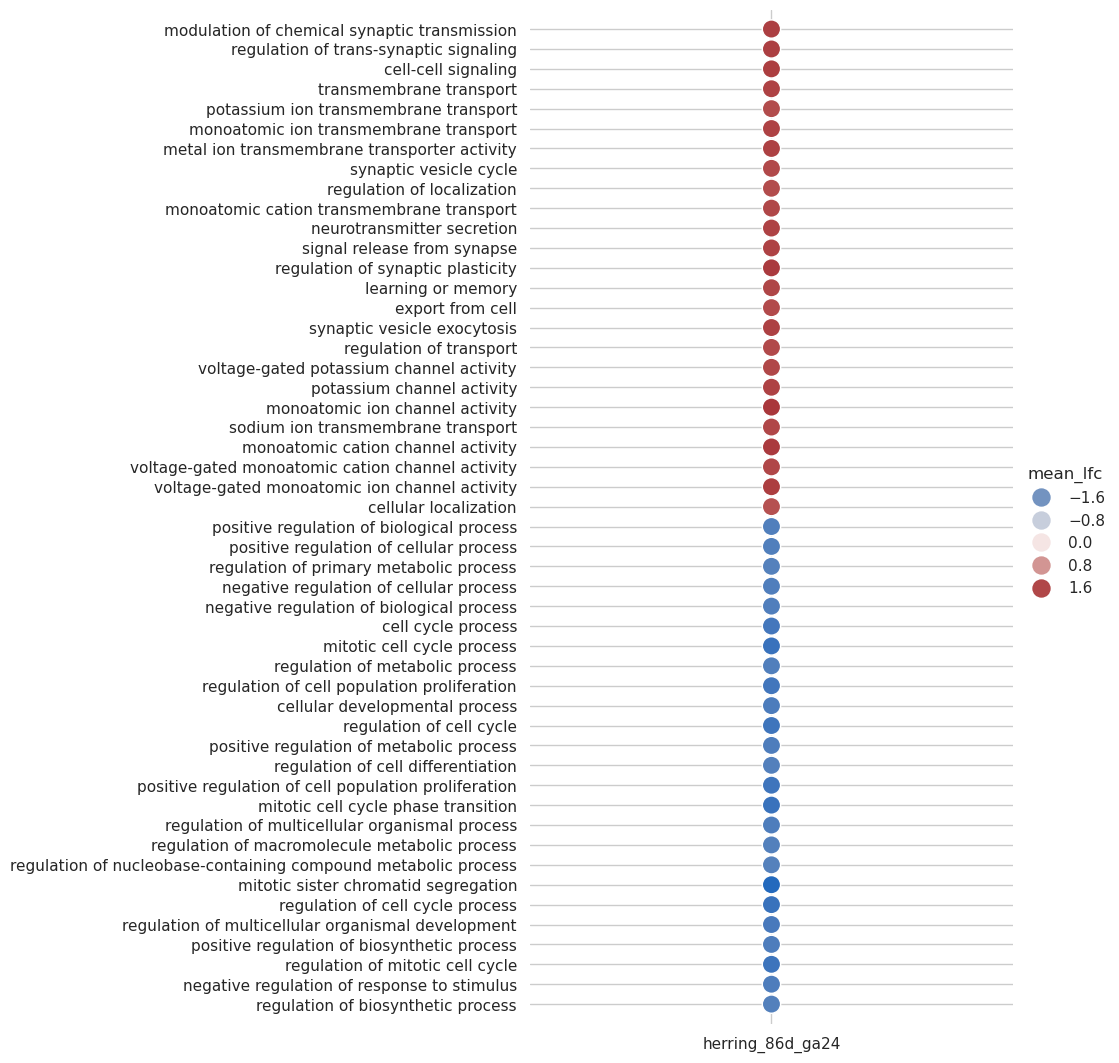

In [138]:
sns.set_theme(style='whitegrid')
g = sns.relplot(data=dotplot_df, x='dataset', y='go_name', hue='mean_lfc',
                palette='vlag', height=11, aspect=1, s=175,
                facet_kws={'legend_out': True})
g.despine(left=True, bottom=True)
g.ax.margins(0.02)
g.set(xlabel='', ylabel='')

In [139]:
# Add data from Sepp datasets
def add_to_dotplot_df_agewise(path, comp, dotplot_df):
    dge = pd.read_csv(str(path+comp), index_col=0)
    go_up = pd.read_csv(str(path+'go_results/all_genes/go_up_'+comp), index_col=0).dropna()
    go_down = pd.read_csv(str(path+'go_results/all_genes/go_down_'+comp), index_col=0).dropna()
    go = pd.concat([go_up, go_down])
    for i in most_enriched.index:
        term = most_enriched.loc[i]
        # Get list of intersecting genes for term
        intersections = go[go['native'] == term['native']]['intersections']
        gene_list = []
        for l in intersections:
            gene_list = gene_list + ast.literal_eval(l)
        # Gene list now contains all DEGs for this cell type associated with the current GO term
        # Get expression data for relevant genes from DEG result
        if len(gene_list) > 0:
            gene_data = dge.loc[gene_list]
            mean_lfc = stats.mean(gene_data['log2FoldChange'])
        else:
            mean_lfc = np.nan
        dotplot_df.loc[len(dotplot_df)] = [comp, term['native'], term['name'], len(gene_list), mean_lfc]
    return dotplot_df

In [144]:
dotplot_df = pd.DataFrame(columns=['dataset', 'go_id', 'go_name', 'num_genes', 'mean_lfc'])
paths = ['/group/ll005/cmcphan/notebooks/analysis/results/sepp/human/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/agewise/']
comps = ['sepp_human_5d_20wpc', 'sepp_mouse_P4_EM13.5', 'sepp_mouse_9w_P7',
         'sepp_opossum_P5_EO14', 'sepp_opossum_P60_P21']
for path, comp in zip(paths, comps):
    dotplot_df = add_to_dotplot_df_agewise(path, comp, dotplot_df)
dotplot_df

dataset       go_id  \
0        herring_86d_ga24  GO:0007267   
1        herring_86d_ga24  GO:0050804   
2        herring_86d_ga24  GO:0099177   
3        herring_86d_ga24  GO:0055085   
4        herring_86d_ga24  GO:0005216   
..                    ...         ...   
295  sepp_opossum_P60_P21  GO:0048519   
296  sepp_opossum_P60_P21  GO:1902679   
297  sepp_opossum_P60_P21  GO:0010556   
298  sepp_opossum_P60_P21  GO:0051254   
299  sepp_opossum_P60_P21  GO:0009893   

                                              go_name  num_genes  mean_lfc  
0                                 cell-cell signaling        203  1.704193  
1        modulation of chemical synaptic transmission        110  1.683708  
2              regulation of trans-synaptic signaling        110  1.683708  
3                             transmembrane transport        215  1.650737  
4                     monoatomic ion channel activity         80  1.768419  
..                                                ...        ...       ...  
295         negative regulation of biological process        195 -2.129554  
296   negative regulation of RNA biosynthetic process          0       NaN  
297  regulation of macromolecule biosynthetic process          0       NaN  
298      positive regulation of RNA metabolic process          0       NaN  
299          positive regulation of metabolic process          0       NaN  

[300 rows x 5 columns]

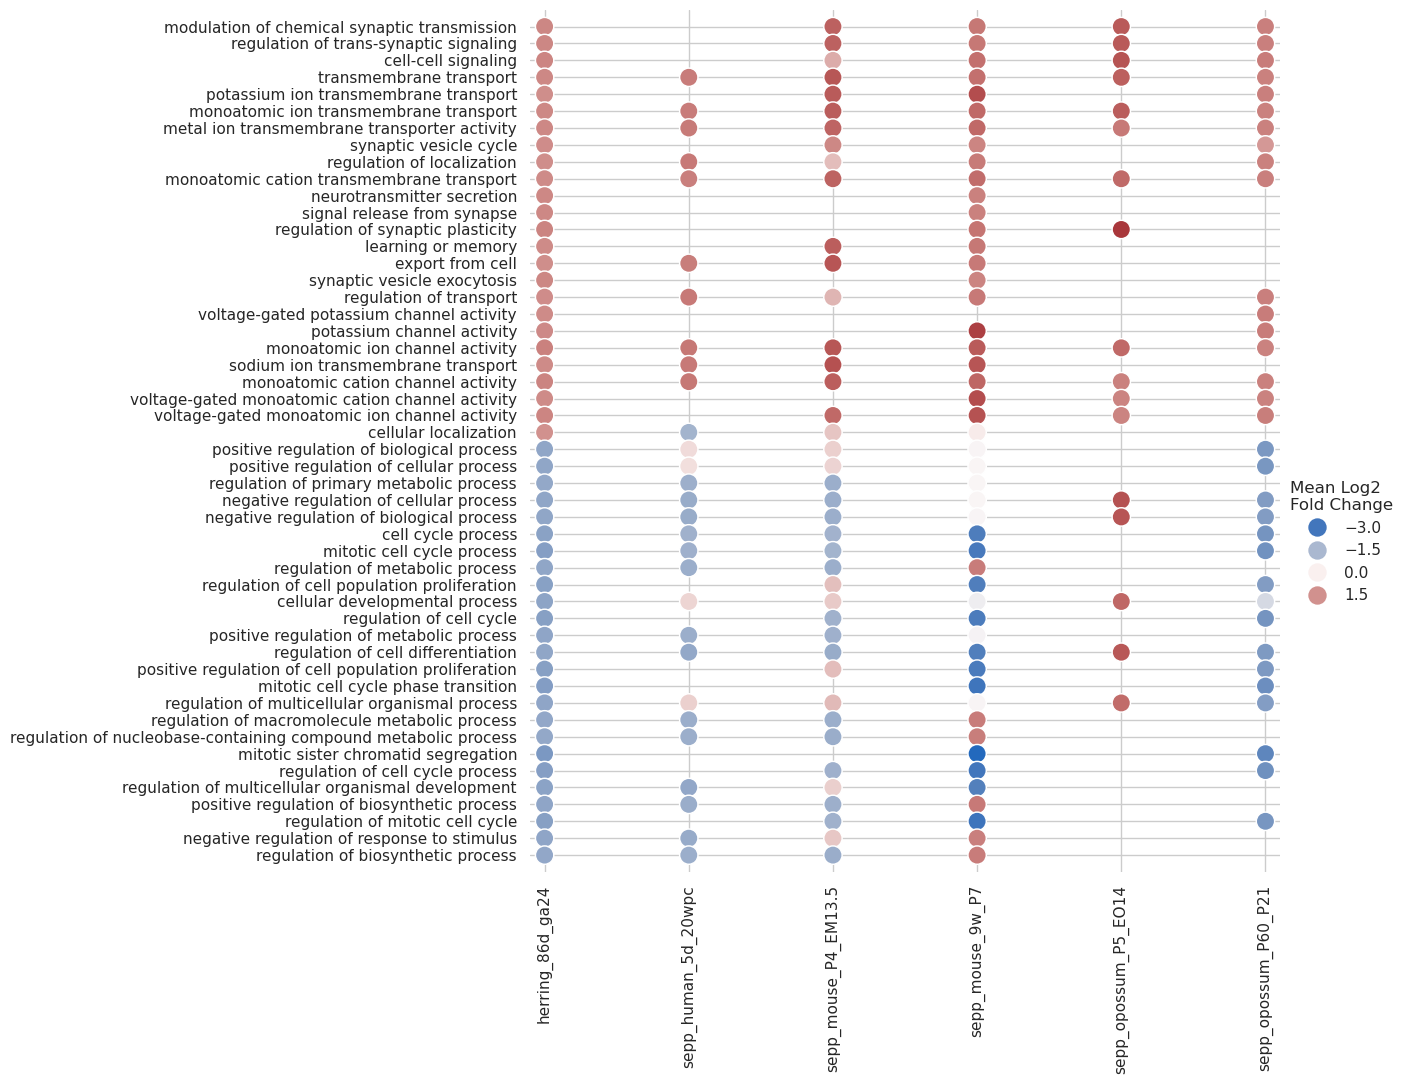

In [141]:
sns.set_theme(style='whitegrid')
g = sns.relplot(data=dotplot_df, x='dataset', y='go_name', hue='mean_lfc',
                palette='vlag', height=11, aspect=1.2, s=175,
                facet_kws={'legend_out': True})
g.despine(left=True, bottom=True)
g.ax.margins(0.02)
g.set_xticklabels(rotation=90)
g.set(xlabel='', ylabel='')
g.legend.set_title('Mean Log2\nFold Change')
g.tight_layout()
g.savefig(str(FIG_PATH+'agewise_go_term_dotplot.svg'), dpi=300, bbox_inches='tight') 

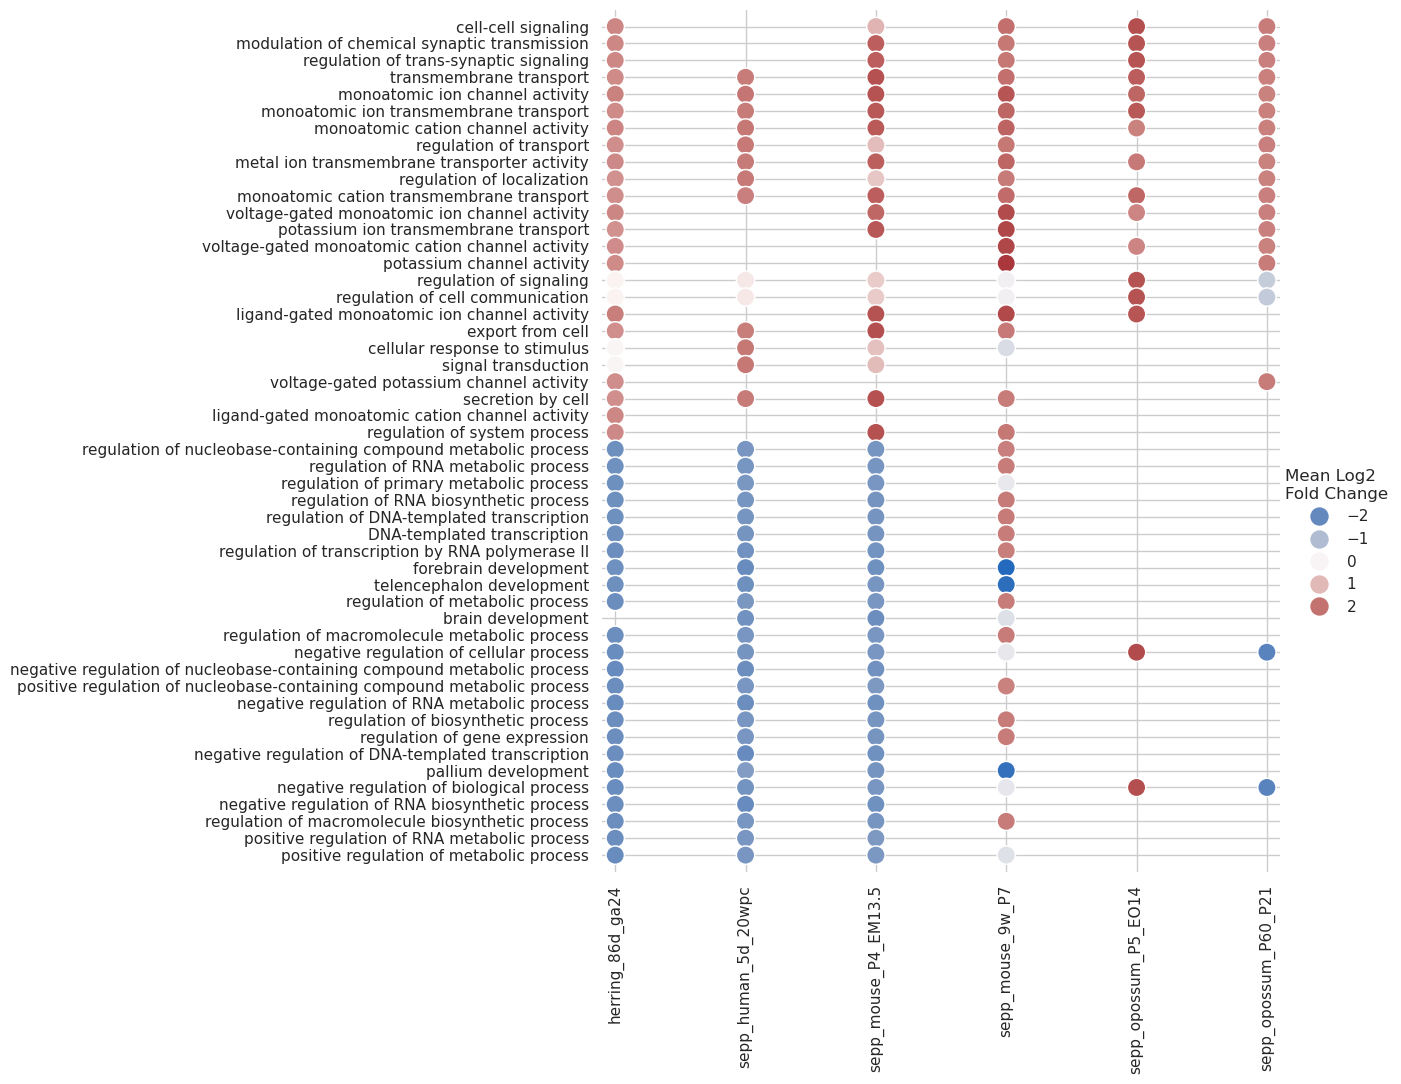

In [145]:
sns.set_theme(style='whitegrid')
g = sns.relplot(data=dotplot_df, x='dataset', y='go_name', hue='mean_lfc',
                palette='vlag', height=11, aspect=1.2, s=175,
                facet_kws={'legend_out': True})
g.despine(left=True, bottom=True)
g.ax.margins(0.02)
g.set_xticklabels(rotation=90)
g.set(xlabel='', ylabel='')
g.legend.set_title('Mean Log2\nFold Change')
g.tight_layout()
g.savefig(str(FIG_PATH+'agewise_go_term_dotplot_stagewise_terms.svg'), dpi=300, bbox_inches='tight') 

The second figure above was generated using the most enriched terms from the cell-type separated results and hence match up much worse overall. The mouse at eye-opening matches the best of all these comparisons, but this gives me the suspicion that it's just because it happens over the longest relative time period. Have a look at some other comps that are just over longer periods of development but don't match with our time points of interest. Try using DEG results to confirm whether the gene sets changing are more or less similar at birth/eye-opening. Opossum differences are also worth investigating as these match up very poorly for some reason.

In [147]:
dotplot_df = pd.DataFrame(columns=['dataset', 'go_id', 'go_name', 'num_genes', 'mean_lfc'])
paths = ['/group/ll005/cmcphan/notebooks/analysis/results/herring/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/human/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/agewise/']
comps = ['herring_8yr_2yr', 'sepp_human_3.5yr_6m', 'sepp_mouse_P4_EM13.5', 'sepp_mouse_9w_P7',
        'sepp_opossum_P42_P21', 'sepp_opossum_P60_P4']
for path, comp in zip(paths, comps):
    dotplot_df = add_to_dotplot_df_agewise(path, comp, dotplot_df)
dotplot_df

dataset       go_id  \
0       herring_86d_ga24  GO:0007267   
1       herring_86d_ga24  GO:0050804   
2       herring_86d_ga24  GO:0099177   
3       herring_86d_ga24  GO:0055085   
4       herring_86d_ga24  GO:0005216   
..                   ...         ...   
345  sepp_opossum_P60_P4  GO:0048519   
346  sepp_opossum_P60_P4  GO:1902679   
347  sepp_opossum_P60_P4  GO:0010556   
348  sepp_opossum_P60_P4  GO:0051254   
349  sepp_opossum_P60_P4  GO:0009893   

                                              go_name  num_genes  mean_lfc  
0                                 cell-cell signaling        203  1.704193  
1        modulation of chemical synaptic transmission        110  1.683708  
2              regulation of trans-synaptic signaling        110  1.683708  
3                             transmembrane transport        215  1.650737  
4                     monoatomic ion channel activity         80  1.768419  
..                                                ...        ...       ...  
345         negative regulation of biological process        183 -2.502575  
346   negative regulation of RNA biosynthetic process         61 -2.570235  
347  regulation of macromolecule biosynthetic process          0       NaN  
348      positive regulation of RNA metabolic process          0       NaN  
349          positive regulation of metabolic process          0       NaN  

[350 rows x 5 columns]

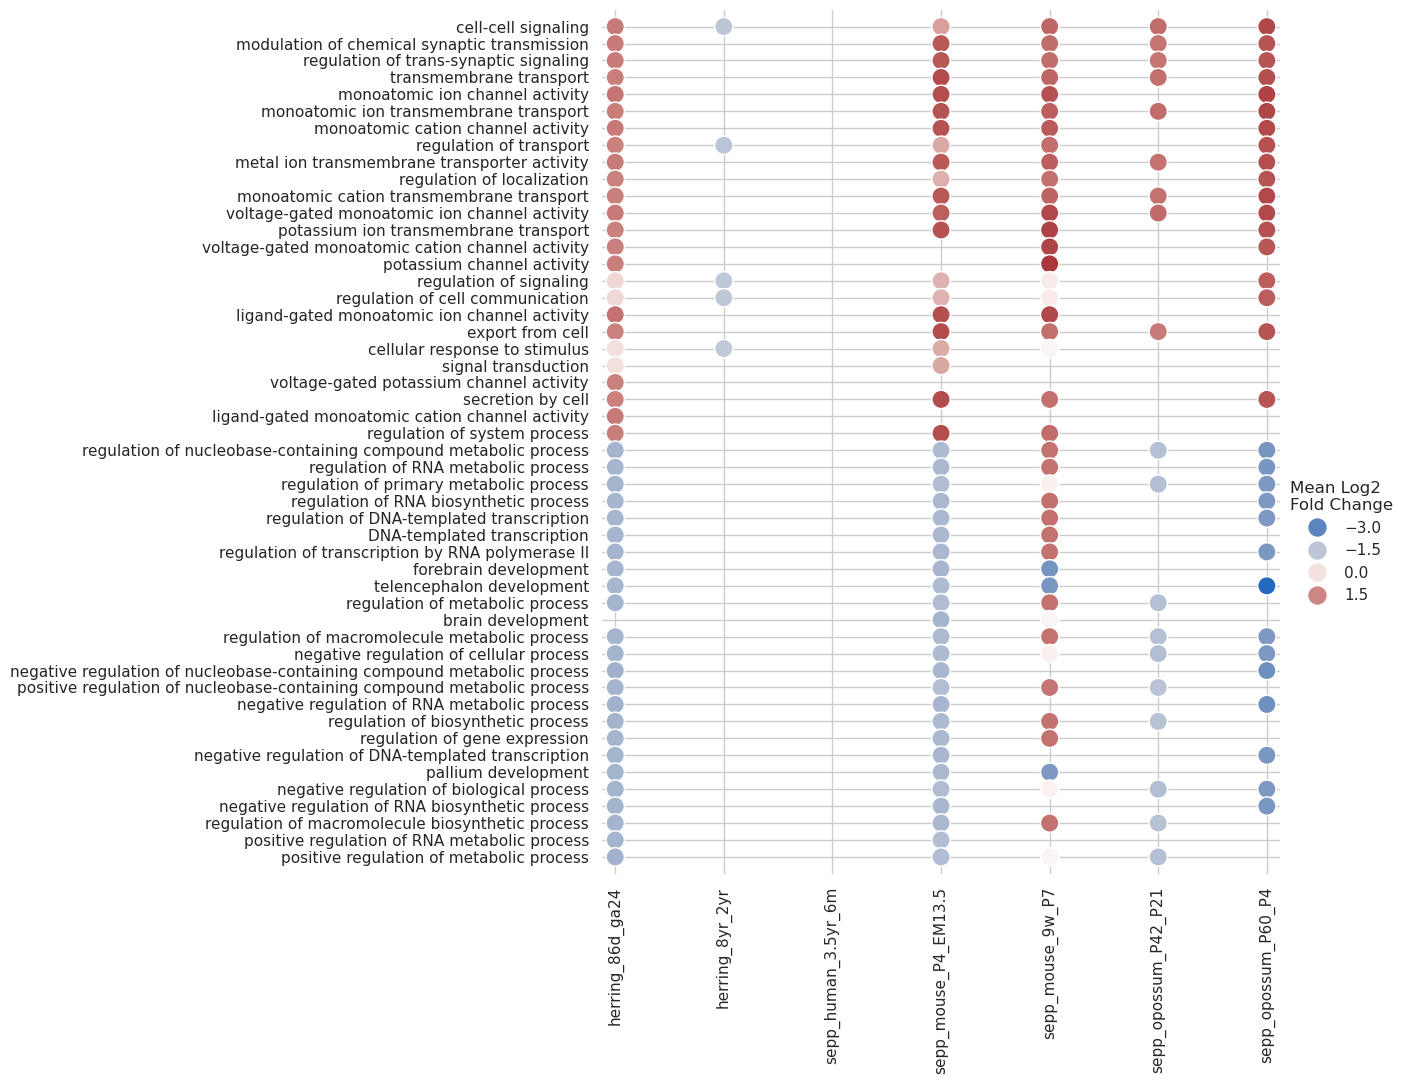

In [148]:
sns.set_theme(style='whitegrid')
g = sns.relplot(data=dotplot_df, x='dataset', y='go_name', hue='mean_lfc',
                palette='vlag', height=11, aspect=1.2, s=175,
                facet_kws={'legend_out': True})
g.despine(left=True, bottom=True)
g.ax.margins(0.02)
g.set_xticklabels(rotation=90)
g.set(xlabel='', ylabel='')
g.legend.set_title('Mean Log2\nFold Change')
g.tight_layout()

Perhaps not, although the opossum long period comparison does match much better than the eye-opening comparison. Maybe because it doesn't have many enriched terms at all?

In [155]:
# Read in all cell type split GO results for a given comparison
upreg = {}
downreg = {}
paths = ['/group/ll005/cmcphan/notebooks/analysis/results/herring/agewise/go_results/',
         '/group/ll005/cmcphan/notebooks/analysis/results/herring/agewise/go_results/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/human/agewise/go_results/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/agewise/go_results/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/agewise/go_results/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/agewise/go_results/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/agewise/go_results/']
comps = ['herring_86d_ga24', 'herring_8yr_2yr', 'sepp_human_3.5yr_6m', 'sepp_mouse_P4_EM13.5', 'sepp_mouse_9w_P7',
        'sepp_opossum_P42_P21', 'sepp_opossum_P60_P4']
prefixes = ['go_up_', 'go_down_']
for path, comp in zip(paths, comps):
    up = {}
    down = {}
    for prefix in prefixes:
            res = pd.read_csv(str(path+prefix+comp), index_col=0)
            if prefix == 'go_up_':
                upreg[comp] = res
            elif prefix == 'go_down_':
                downreg[comp] = res

In [156]:
len(upreg['sepp_opossum_P42_P21'])

47

In [157]:
len(downreg['sepp_opossum_P42_P21'])

53

In [158]:
len(upreg['herring_86d_ga24'])

399

In [159]:
len(downreg['herring_86d_ga24'])

444

Certainly far fewer overall enriched terms - try a comparison over a longer time period?

In [160]:
dotplot_df = pd.DataFrame(columns=['dataset', 'go_id', 'go_name', 'num_genes', 'mean_lfc'])
paths = ['/group/ll005/cmcphan/notebooks/analysis/results/sepp/human/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/agewise/']
comps = ['sepp_human_6m_20wpc', 'sepp_mouse_P4_EM13.5', 'sepp_mouse_9w_P7',
         'sepp_opossum_P42_P21', 'sepp_opossum_P60_P14', 'sepp_opossum_P60_P21']
for path, comp in zip(paths, comps):
    dotplot_df = add_to_dotplot_df_agewise(path, comp, dotplot_df)
dotplot_df

dataset       go_id  \
0     sepp_human_6m_20wpc  GO:0007267   
1     sepp_human_6m_20wpc  GO:0050804   
2     sepp_human_6m_20wpc  GO:0099177   
3     sepp_human_6m_20wpc  GO:0055085   
4     sepp_human_6m_20wpc  GO:0005216   
..                    ...         ...   
295  sepp_opossum_P60_P21  GO:0048519   
296  sepp_opossum_P60_P21  GO:1902679   
297  sepp_opossum_P60_P21  GO:0010556   
298  sepp_opossum_P60_P21  GO:0051254   
299  sepp_opossum_P60_P21  GO:0009893   

                                              go_name  num_genes  mean_lfc  
0                                 cell-cell signaling        168  2.571020  
1        modulation of chemical synaptic transmission          0       NaN  
2              regulation of trans-synaptic signaling          0       NaN  
3                             transmembrane transport        274  2.515017  
4                     monoatomic ion channel activity         97  2.554407  
..                                                ...        ...       ...  
295         negative regulation of biological process        195 -2.129554  
296   negative regulation of RNA biosynthetic process          0       NaN  
297  regulation of macromolecule biosynthetic process          0       NaN  
298      positive regulation of RNA metabolic process          0       NaN  
299          positive regulation of metabolic process          0       NaN  

[300 rows x 5 columns]

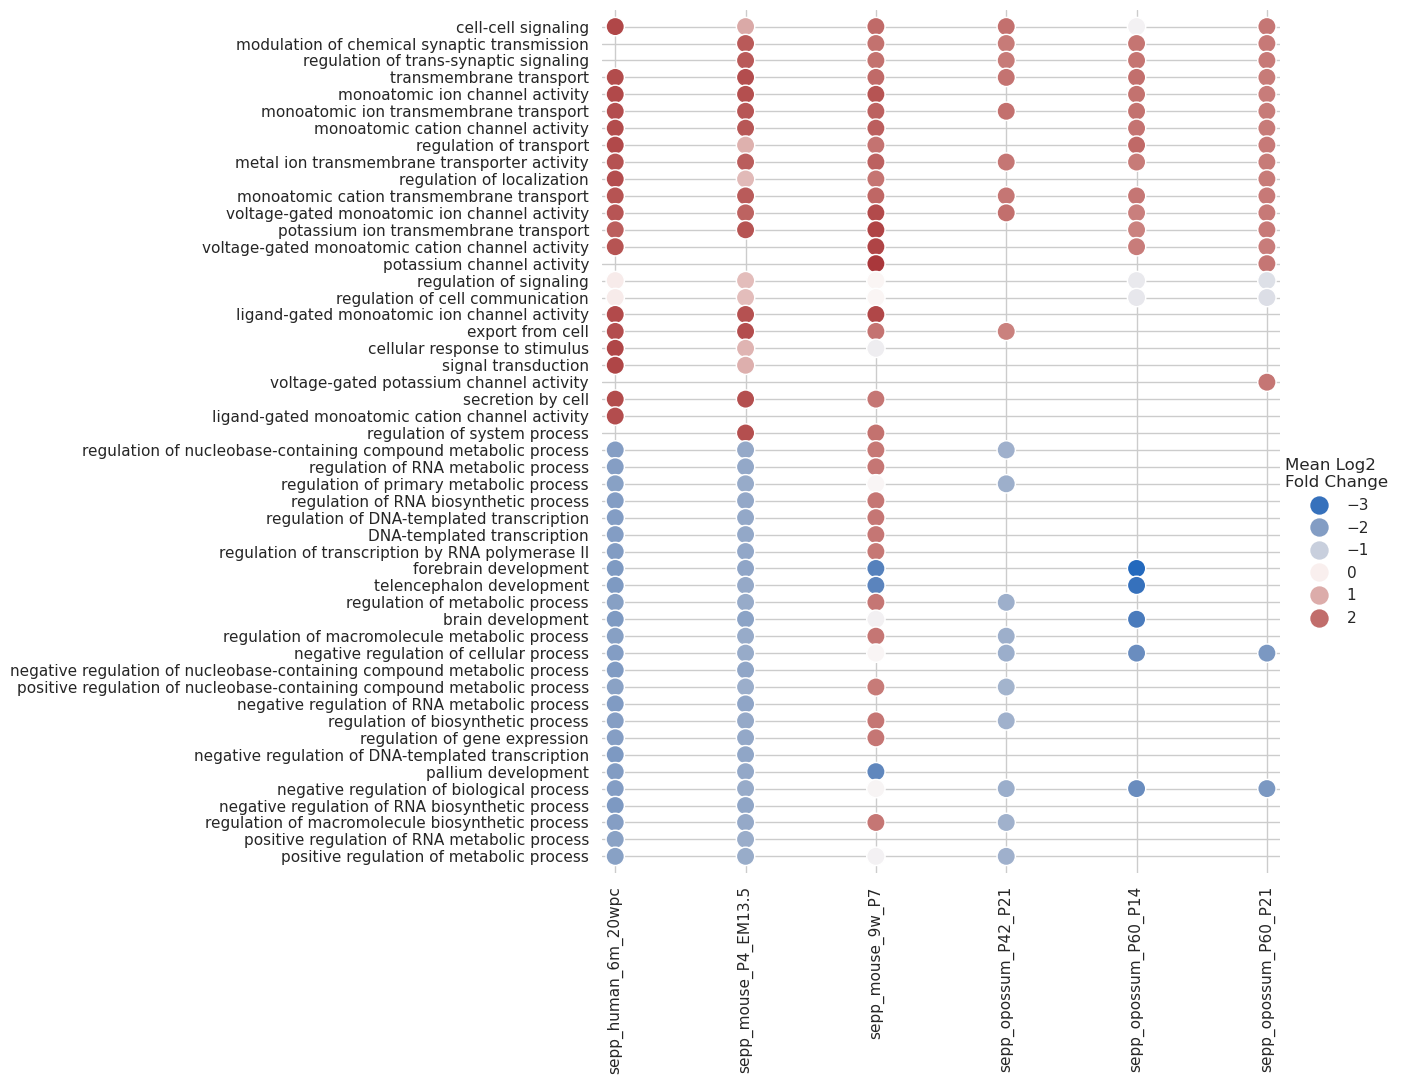

In [161]:
sns.set_theme(style='whitegrid')
g = sns.relplot(data=dotplot_df, x='dataset', y='go_name', hue='mean_lfc',
                palette='vlag', height=11, aspect=1.2, s=175,
                facet_kws={'legend_out': True})
g.despine(left=True, bottom=True)
g.ax.margins(0.02)
g.set_xticklabels(rotation=90)
g.set(xlabel='', ylabel='')
g.legend.set_title('Mean Log2\nFold Change')
g.tight_layout()

P21 to P60 comparison seems to give more comparable results. Additionally, neither the 20wpc to 5d nor the 20wpc to 6m comparisons for the Sepp human data match very well at all with the terms generated through either method. This may be because of the large changes in cell type proportions confounding the data, or because the dataset is of overall lower quality, though it is difficult to tell.

In [164]:
dotplot_df = pd.DataFrame(columns=['dataset', 'go_id', 'go_name', 'num_genes', 'mean_lfc'])
paths = ['/group/ll005/cmcphan/notebooks/analysis/results/herring/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/human/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/agewise/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/agewise/']
comps = ['herring_86d_ga24', 'sepp_human_5d_20wpc', 'sepp_mouse_P4_EM13.5', 'sepp_mouse_9w_P7',
         'sepp_opossum_P5_EO14', 'sepp_opossum_P60_P21']
for path, comp in zip(paths, comps):
    dotplot_df = add_to_dotplot_df_agewise(path, comp, dotplot_df)
dotplot_df

dataset       go_id  \
0        herring_86d_ga24  GO:0007267   
1        herring_86d_ga24  GO:0050804   
2        herring_86d_ga24  GO:0099177   
3        herring_86d_ga24  GO:0055085   
4        herring_86d_ga24  GO:0005216   
..                    ...         ...   
295  sepp_opossum_P60_P21  GO:0048519   
296  sepp_opossum_P60_P21  GO:1902679   
297  sepp_opossum_P60_P21  GO:0010556   
298  sepp_opossum_P60_P21  GO:0051254   
299  sepp_opossum_P60_P21  GO:0009893   

                                              go_name  num_genes  mean_lfc  
0                                 cell-cell signaling        203  1.704193  
1        modulation of chemical synaptic transmission        110  1.683708  
2              regulation of trans-synaptic signaling        110  1.683708  
3                             transmembrane transport        215  1.650737  
4                     monoatomic ion channel activity         80  1.768419  
..                                                ...        ...       ...  
295         negative regulation of biological process        195 -2.129554  
296   negative regulation of RNA biosynthetic process          0       NaN  
297  regulation of macromolecule biosynthetic process          0       NaN  
298      positive regulation of RNA metabolic process          0       NaN  
299          positive regulation of metabolic process          0       NaN  

[300 rows x 5 columns]

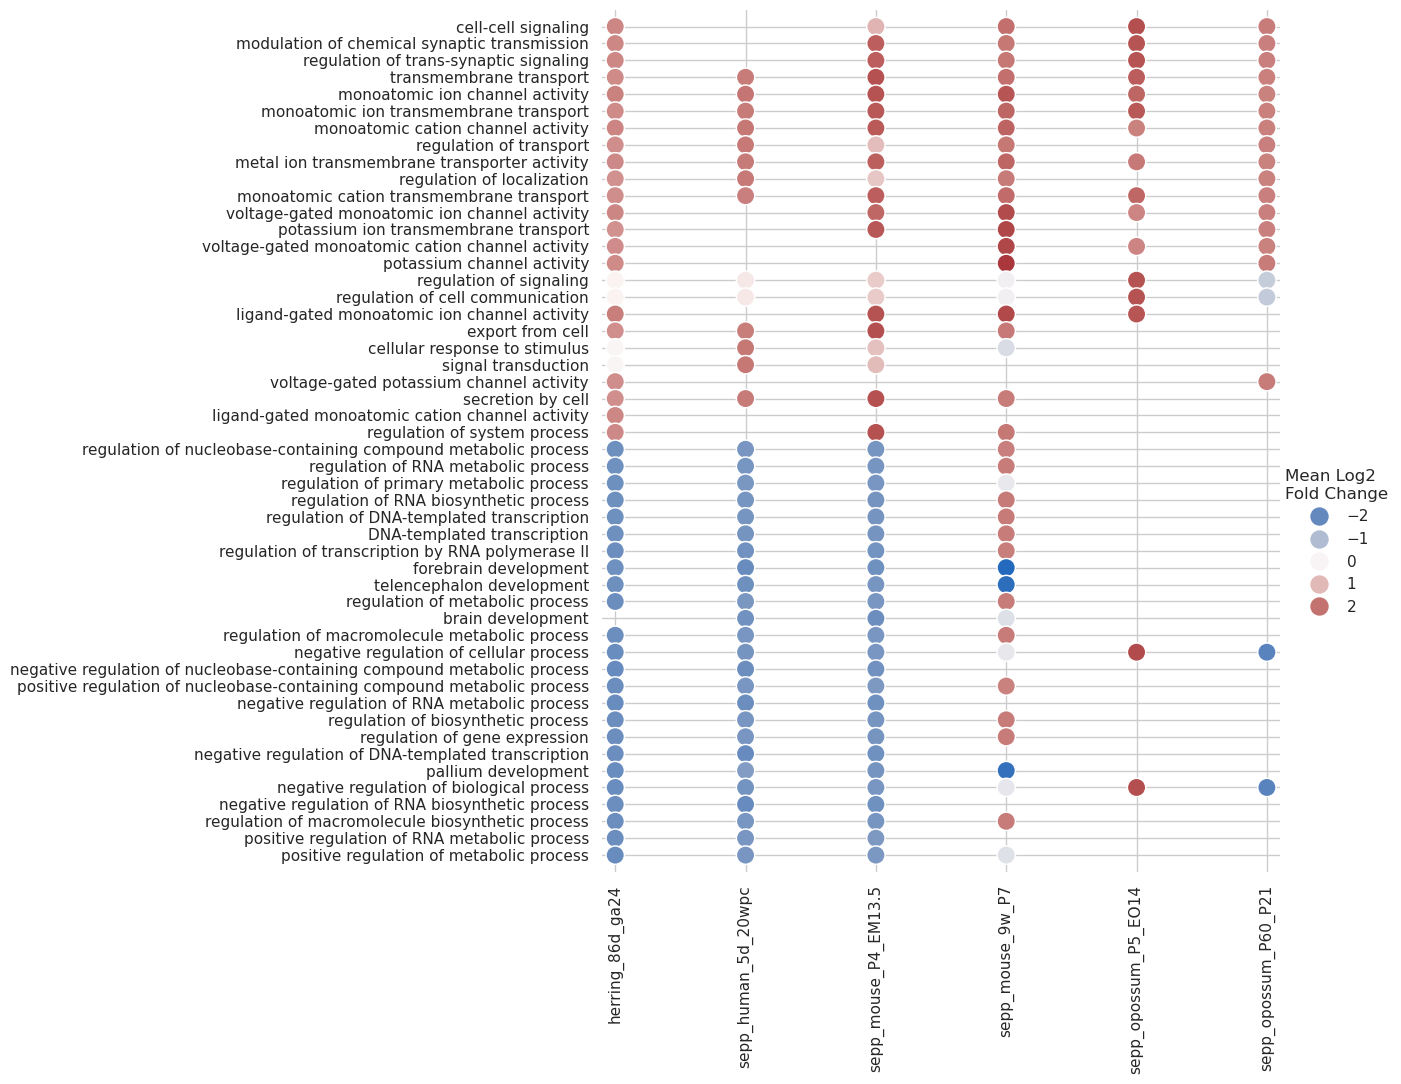

In [165]:
sns.set_theme(style='whitegrid')
g = sns.relplot(data=dotplot_df, x='dataset', y='go_name', hue='mean_lfc',
                palette='vlag', height=11, aspect=1.2, s=175,
                facet_kws={'legend_out': True})
g.despine(left=True, bottom=True)
g.ax.margins(0.02)
g.set_xticklabels(rotation=90)
g.set(xlabel='', ylabel='')
g.legend.set_title('Mean Log2\nFold Change')
g.tight_layout()
g.savefig(str(FIG_PATH+'agewise_go_term_dotplot_stagewise_terms.svg'), dpi=300, bbox_inches='tight') 

Generate summary of most enriched terms for each of our time points of interest to see how the mouse eye-opening group stacks up.

In [166]:
def check_enrichment_agewise(path, comp):
    # Read in all cell type split GO results for a given comparison
    upreg = []
    downreg = []
    prefixes = ['go_up_', 'go_down_']
    for prefix in prefixes:
        for cell_type in cell_types:
            res = pd.read_csv(str(path+prefix+comp), index_col=0)
            if prefix == 'go_up_':
                upreg.append(res)
            elif prefix == 'go_down_':
                downreg.append(res)
    # Generate list of most enriched terms for each result, remove any terms that appear in both the up and down regulated lists
    most_enriched_up = pd.DataFrame(columns=['source', 'native', 'name'])
    most_enriched_down = pd.DataFrame(columns=['source', 'native', 'name'])
    for up, down in zip(upreg, downreg):
        # Get only the GO terms which are not also in the opposite results for the same cell type - i.e. those that are 
        #    uniquely up- or down-regulated
        unique_up = up[up['source'].isin(['GO:BP', 'GO:MF', 'KEGG', 'REAC', 'WP'])].sort_values(by='p_value')[['source', 'native', 'name', 'parents']]
        unique_up_ids = [g for g in unique_up['native'].values if g not in down['native'].values]
        unique_up = up[up['native'].isin(unique_up_ids)]
        unique_up = unique_up.loc[[True if len(ast.literal_eval(p)) >= 2 else False for p in unique_up['parents'].values]]
        most_enriched_up = pd.concat([most_enriched_up, unique_up]).drop_duplicates()
        unique_down = down[down['source'].isin(['GO:BP', 'GO:MF', 'KEGG', 'REAC', 'WP'])].sort_values(by='p_value')[['source', 'native', 'name', 'parents']]
        unique_down_ids = [g for g in unique_down['native'].values if g not in up['native'].values]
        unique_down = down[down['native'].isin(unique_down_ids)]
        unique_down = unique_down.loc[[True if len(ast.literal_eval(p)) >= 2 else False for p in unique_down['parents'].values]]
        most_enriched_down = pd.concat([most_enriched_down, unique_down]).drop_duplicates()
    most_enriched_up.reset_index(inplace=True, drop=True)
    most_enriched_up = most_enriched_up.sort_values(by='p_value')
    up = pd.DataFrame(columns=['source', 'native', 'name'])
    for i in range(0, len(most_enriched_up)):
        if len(up) >= 25:
            break
        term = most_enriched_up.iloc[i]
        if term['native'] in up['native'].values:
            continue
        else:
            up.loc[len(up)] = term[['source', 'native', 'name']]
    most_enriched_down.reset_index(inplace=True, drop=True)
    most_enriched_down = most_enriched_down.sort_values(by='p_value')
    down = pd.DataFrame(columns=['source', 'native', 'name'])
    for i in range(0, len(most_enriched_down)):
        if len(down) >= 25:
            break
        term = most_enriched_down.iloc[i]
        if term['native'] in down['native'].values:
            continue
        else:
            down.loc[len(down)] = term[['source', 'native', 'name']]
    return {'up': up, 'down': down}

In [167]:
paths = ['/group/ll005/cmcphan/notebooks/analysis/results/herring/agewise/go_results/all_genes/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/human/agewise/go_results/all_genes/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/agewise/go_results/all_genes/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/agewise/go_results/all_genes/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/agewise/go_results/all_genes/',
         '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/agewise/go_results/all_genes/']
comps = ['herring_86d_ga24', 'sepp_human_5d_20wpc', 'sepp_mouse_P4_EM13.5', 'sepp_mouse_9w_P7',
         'sepp_opossum_P5_EO14', 'sepp_opossum_P60_P21']
summary = pd.DataFrame()
directions = list(['up']*25 + ['down']*25)
summary['direction'] = directions
for path, comp in zip(paths, comps):
    enriched = check_enrichment_agewise(path, comp)
    top_up = enriched['up']['name'].values.tolist()[:25]
    top_down = enriched['down']['name'].values.tolist()[:25]
    while len(top_up) < 25:
        top_up.append(None)
    while len(top_down) < 25:
        top_down.append(None)
    summary[comp] = list(top_up + top_down)
summary.to_csv(str('/group/ll005/cmcphan/notebooks/analysis/results/'+'agewise_go_terms_results_summary.csv'))
summary

direction                                   herring_86d_ga24  \
0         up       modulation of chemical synaptic transmission   
1         up             regulation of trans-synaptic signaling   
2         up                                cell-cell signaling   
3         up                            transmembrane transport   
4         up              potassium ion transmembrane transport   
5         up             monoatomic ion transmembrane transport   
6         up       metal ion transmembrane transporter activity   
7         up                             synaptic vesicle cycle   
8         up                         regulation of localization   
9         up          monoatomic cation transmembrane transport   
10        up                         neurotransmitter secretion   
11        up                        signal release from synapse   
12        up                  regulation of synaptic plasticity   
13        up                                 learning or memory   
14        up                                   export from cell   
15        up                        synaptic vesicle exocytosis   
16        up                            regulation of transport   
17        up           voltage-gated potassium channel activity   
18        up                         potassium channel activity   
19        up                    monoatomic ion channel activity   
20        up                 sodium ion transmembrane transport   
21        up                 monoatomic cation channel activity   
22        up   voltage-gated monoatomic cation channel activity   
23        up      voltage-gated monoatomic ion channel activity   
24        up                              cellular localization   
25      down          positive regulation of biological process   
26      down            positive regulation of cellular process   
27      down            regulation of primary metabolic process   
28      down            negative regulation of cellular process   
29      down          negative regulation of biological process   
30      down                                 cell cycle process   
31      down                         mitotic cell cycle process   
32      down                    regulation of metabolic process   
33      down        regulation of cell population proliferation   
34      down                     cellular developmental process   
35      down                           regulation of cell cycle   
36      down           positive regulation of metabolic process   
37      down                 regulation of cell differentiation   
38      down  positive regulation of cell population prolife...   
39      down                mitotic cell cycle phase transition   
40      down     regulation of multicellular organismal process   
41      down      regulation of macromolecule metabolic process   
42      down  regulation of nucleobase-containing compound m...   
43      down               mitotic sister chromatid segregation   
44      down                   regulation of cell cycle process   
45      down  regulation of multicellular organismal develop...   
46      down        positive regulation of biosynthetic process   
47      down                   regulation of mitotic cell cycle   
48      down        negative regulation of response to stimulus   
49      down                 regulation of biosynthetic process   

                                  sepp_human_5d_20wpc  \
0                             transmembrane transport   
1                       cellular response to stimulus   
2              monoatomic ion transmembrane transport   
3            intracellular monoatomic ion homeostasis   
4                                 signal transduction   
5         intracellular monoatomic cation homeostasis   
6                  intracellular chemical homeostasis   
7                       import across plasma membrane   
8           monoatomic cation transmembrane transport   
9              

The opossum neonatal comparison really doesn't work well here because of the small time period compared to the other samples - limited by the data itself. As such we are missing a key comparison in both the stagewise and agewise data, with no good way to marry the two since one controls for cell type and the other doesn't. GO terms in the neurons seem to be pretty concordant overall all things considered, though this is difficult to objectively quantify. Hopefully comparisons of the DEGs themselves will reveal some patterning we can use to judge similarity more robustly.